# ARIMA Modelling on Australian Retail Sales Data 2013 to 2025

This notebook includes the preprocessing and implantation of an ARIMA model on Australian retail sales data. The data spans across the COVID period that impact the trend. Various pre-processing techniques are used to evaluate their effectiveness in accounting for this variation and producing accurate forecasts.

- Author: Adi Selak
- Last Edit: 4/10/2025

- Dataset: The dataset can be found on the ABS website under Online Retail Sales: https://www.abs.gov.au/statistics/industry/retail-and-wholesale-trade/retail-trade-australia/latest-release

- ARIMA: The Autoregresssive Integrated Moving Average is a forecasting model that combines autoregression, differencing, and moving averages to model time series data. It removes trends by differencing, allowing the model to capture the underlying changes in the data.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from workalendar.oceania.australia import Australia
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import normaltest
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from itertools import product
from typing import Union
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.simplefilter(action='ignore')
pd.set_option('display.max_rows', None)

In [9]:
class Utility:
    """
    Utility: A utility function that streamlines the process of transforming, plotting, and predicting time-series data. The function was also created to provide options
    to add a global theme for different visualisations.

    Attributes:
        - data (pd.DataFrame) Stores data used by the transformation function for inverse transform.
        - n_diff (list) Stores the values used in differencing for inverse transform.
        - n_season (pd.DataFrame) Stores the values used for season differencing for inverse transform.
        - params (dict) A dictionary of flags for inverse transform.
        - scaler (MinMaxScaler, StandardScaler) Stores the scaler for inverse transform.

    """
    def __init__(self):
        self.data = None
        self.n_diff = []
        self.n_season = None
        self.params = None
        self.scaler = None
       
    def pt_histogram(self, data: pd.DataFrame, variable: str, title: str=None):
        """
        pt_histogram: Plots a histogram with confidence intervals for the interquartile range and outliers (1.5*IQR) for a given variable.

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable to plot.
            - variable (string) The variable to plot.
            - title (string) The full title for the Histogram.

        """
        # Default if no title is given.
        if title == None:
            title = f"Histogram of {variable}"

        # Calculate intervals.
        q1 = data[variable].quantile(0.25)
        q3 = data[variable].quantile(0.75)
        iqr = q3 - q1
        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr

        # Create sns plot with intervals.
        plt.figure(figsize=(12, 6))
        ax = sns.histplot(data[variable], 
                          bins=30, 
                          kde=True, 
                          color='#008080', 
                          alpha=0.4)
        ax.lines[0].set_color('#fa8072')
        plt.axvline(q1, color='#ffa500', linestyle='--', linewidth=2, label='IQR')
        plt.axvline(q3, color='#ffa500', linestyle='--', linewidth=2)
        plt.axvline(lower_fence, color='red', linestyle='--', linewidth=1, label='Lower Outliers', alpha=0.4)
        plt.axvline(upper_fence, color='red', linestyle='--', linewidth=1, label='Upper Outliers', alpha=0.4)
        plt.title(title)
        plt.xlabel('Sales')
        plt.ylabel('Frequency')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Run Normality test and print significance.
        stat, pvalue = normaltest(data[variable])
        print(f"Normality Test Statistic: {stat:.3f}")
        print(f"p-value: {pvalue:.6f}")
        if pvalue > 0.05:
            print('The distribution is likely Normal.')
        else:
            print('The distribution is not Normal.')
    
    def pt_time(self, data: pd.DataFrame, variable: str, seasonal_dates: list=None, highlights: list=None, test: pd.DataFrame=None, preds: list=None, title: str=None):
        """ 
        pt_time: Plot a time-series with functionalities to add seasonal dates as points, highlighted sections and seperate lines for a test sets
        or predictions.

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable to plot and the indexes for the variable and training set.
            - variable (string) The variable to plot.
            - seasonal_dates (list) A dictionary list containing seasonal data from the plotted variable in the form of {label:, data:, color:}.
            - highlights (list) A dictionary list containing an index range to highlight in the form of {start:, end:, color:, label:}.
            - test (pd.DataFrame) A seperate test set that plots the actual data and holds the index for predictions.
            - preds (list) A dictionary list containing data for the predictions on the test set in the form of {data:, color:, label:}.
            - title (string) The full title used for the plot.

        """
        # Default if no title given.
        if title == None:
            title = f"Time-Series of {variable}"
        
        # Initial plot of data or training set.
        plt.figure(figsize=(16, 8))
        ax = sns.lineplot(data=data, 
                          x=data.index, 
                          y='Sales', 
                          color='#008080', 
                          alpha=0.4)
        plt.title(title)
        plt.ylabel('Sales')
        plt.xlabel('Year')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
        ax.xaxis.set_major_locator(mdates.YearLocator())
        plt.xticks()

        # Plot seasonal dates as point marks.
        if seasonal_dates:
            for s in seasonal_dates:
                ax.scatter(s['data'].index, s['data'][variable], color=s['color'], s=30, marker='o', label=s['label'])

        # Plot highlights with filled vertical lines.
        if highlights:
            for h in highlights:
                ax.axvspan(h['start'], h['end'], alpha=0.3, color=h['color'], label=h['label'])
        
        # Plot the test set.
        if test is not None:
            sns.lineplot(x=test.index, y=test['Sales'], color='#666666', alpha=0.8, label='Test', ax=ax)
        
        # Plot predictions.
        if preds:
            for p in preds:
                sns.lineplot(x=test.index, y=p['data'], color=p['color'], alpha=0.8, label=p['label'], ax=ax)
        
        ax.legend(loc='upper left')
        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()

    def pt_mean_var(self, data: pd.DataFrame, variable: str, title: str=None):
        """
        pt_mean_var: Plot the cumulative mean and cumulative variance of a given variable as side-by-side subplots.

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable to plot.
            - variable (string) The variable to plot.
            - title (string) The full title used for the plot.

        """
        # Calculate values
        mean = self.get_cumulative_mean(data[variable])
        var = self.get_cumulative_var(data[variable])

        # Set sub-plots.
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))

        # Plot cumulative mean.
        sns.lineplot(x=data.index, y=mean, color='#008080', alpha=0.7, ax=axes[0])
        if title == None:
            axes[0].set_title(f"Cumulative Mean of {variable}")
        else:
            axes[0].set_title(f"Cumulative Mean of {title}")
        axes[0].set_ylabel('Sales')
        axes[0].set_xlabel('Year')
        axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axes[0].xaxis.set_major_locator(mdates.YearLocator())
        axes[0].grid(True, alpha=0.3)
        
        # Plot cumulative variance.
        sns.lineplot(x=data.index, y=var, color='#ff7f50', alpha=0.7, ax=axes[1])
        if title == None:
            axes[1].set_title(f"Cumulative Variance of {variable}")
        else:
            axes[1].set_title(f"Cumulative Variance of {title}")
        axes[1].set_ylabel('Variance')
        axes[1].set_xlabel('Year')
        axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axes[1].xaxis.set_major_locator(mdates.YearLocator())
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def pt_stl(self, data: pd.DataFrame, variable: str, period: int=None, title: str=None):
        """
        pt_stl: Plot a Seasonal-Trend Decomposition using LOESS. The process plots the original data and and 3 components using LOESS smoothing (trend, season, and residuals).

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable to plot.
            - variable (string) The variable to plot.
            - period (integer) The period (step) for each season.
            - title (string) The full title used for the plot.

        https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html

        """
        # Get STL compositions.
        stl = STL(data[variable], period=period, robust=True)
        result = stl.fit()

        # Create sub-plots with universal x-axis.
        fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
        
        # Plot Original Data.
        axes[0].plot(data.index, data[variable], color='#008080', label='Actual', alpha=0.7)
        axes[0].set_title('Actual')

        # Plot Trend.
        axes[1].plot(result.trend.index, result.trend, color='#008080', linewidth=2, label='Trend', alpha=0.7)
        axes[1].set_title('Trend')

        # Plot Seasons.
        axes[2].plot(result.seasonal.index, result.seasonal, color='#008080', linewidth=2, label='Seasonal', alpha=0.7)
        axes[2].set_title('Seasonal')

        # Plot Residuals.
        axes[3].axhline(0, color='#ff7f50', linewidth=2, alpha=0.7)
        axes[3].scatter(result.resid.index, result.resid, color='#008080', s=30, label='Residuals', alpha=0.7)
        axes[3].set_title('Residual')

        # Default title if not given.
        if title == None:
            title = f"STL Decomposition of {variable}"
        fig.suptitle(title)

        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def pt_acf(self, data: pd.DataFrame, variable: str, lags: int, type_of: str=None, title: str=None):
        """
        pt_acf: Plot the Autocorrelation or Partial Autocorrelation function. This function helps to evaluate the type of data and its suitability for different models.

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable to plot.
            - variable (string) The variable to plot.
            - lags (integer) The number of lags to plot (must be n_observations-1 for acf and (n_observations-1)/2 for pacf).
            - type_of (string) 'partial' for Partial Autocorrelation function.
            - title (string) The full title used for the plot.
        
        plot_acf - https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
        plot_pacf - https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

        """
        # If type is partial plot Partial Autocorrelation Function.
        if type_of == 'partial':
            fig, ax = plt.subplots(figsize=(12, 6))
            plot_pacf(data[variable],
                      lags=lags,
                      ax=ax,
                      vlines_kwargs={'color': '#ff7f50', 'linewidth': 1, 'alpha': 0.5},
                      alpha=0.7,
                      color='#008080')
            ax.set_title(title)
            ax.set_xlabel('Lags')
            ax.set_ylabel('Autocorrelation')
            plt.tight_layout()
            plt.grid(True, alpha=0.3)
            plt.show()
        
        # If type is not given plot Standard Autocorrelation Function.
        else:
            fig, ax = plt.subplots(figsize=(12, 6))
            plot_acf(data[variable],
                     lags=lags,
                     ax=ax,
                     vlines_kwargs={'color': '#ff7f50', 'linewidth': 1, 'alpha': 0.5},
                     alpha=0.7,
                     color='#008080'
                     )
            ax.axhline(y=0, color='#008080', linestyle='-.', linewidth=1.5)
            ax.set_title(title)
            ax.set_xlabel('Lags')
            ax.set_ylabel('Autocorrelation')
            plt.tight_layout()
            plt.grid(True, alpha=0.3)
            plt.show()
    
    def pt_preds(self, preds: list, title: str=None, type_of: str='mape'):
        """
        pt_preds: Plot the Mean Absolute Percentage Error in a bar plot for the given predictions.

        Parameters:
            - preds (list) A list of dictionaries containing predictions in the form of {label:, mape:, color:}.
            - title (string) The full title for the MAPE plot.
            - type_of (string) The type of calculation used (mape requires graph axis scaling).

        """
        labels = []
        mape_results = []
        colors = []

        # Loop through dictionary and create lists of results.
        for p in preds:
            labels.append(p['label'])
            mape_results.append(p['result'])
            colors.append(p['color'])
        
        # Plot Results.
        plt.figure(figsize=(10, 6))
        sns.barplot(x=labels, y=mape_results, palette=colors)
        if title == None:
            title = 'Mean Absolute Percentage Error for Different Forecast Methods'
        plt.title(title)
        plt.ylabel('MAPE (%)')
        plt.xlabel('Forecast Method')

        # Set y-axis to 100 if MAPE.
        if type_of == 'mape':
            plt.ylim(0, 100)
        
        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Print relevant metric.
        if type_of == 'mape':
            x = 'Mean Absolute Percentage Error'
        if type_of == 'rmse':
            x = 'Root Mean Squared Error'

        for p in preds:
            print(f"{x} for {p['label']}: {round(p['result'], 3)}")

    def pt_model_fit(self, residuals: np.array, title: str=None, lj_lags: int=10):
        """
        pt_model_fit: Plot a QQ-Plot and print the Ljung-Box test for a given set of lags on the residuals from a model. This function helps to evaluate the model 
        fit on the data.

        Parameters:
            - residuals (np.array) The residuals after fitting a model.
            - title (string) The full title to use for the QQ-Plot.
            - lj_lags (integer) The number of lags to print to evaluate the significance.

        Ljung-Box - https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html

        """
        # Create the subplot mask for customisation of stats plot.
        fig, ax = plt.subplots(figsize=(16, 8))
        qqplot(residuals, line='45', ax=ax)

        # Customise point elements.
        points = ax.get_lines()[0]       
        points.set_markerfacecolor('#008080')
        points.set_markeredgecolor('#008080')
        points.set_alpha(0.5)
        points.set_markersize(8)

        # Customise line elements.
        line = ax.get_lines()[1]
        line.set_color('#ff7f50')
        line.set_alpha(0.8)
        line.set_linewidth(1.5)

        # If title is not given set title.
        if title == None:
            title = 'QQ-Plot of Model Residuals'
        ax.set_title(title)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print Ljung-Box statistics.
        lj_result = acorr_ljungbox(residuals, lags=np.arange(1, lj_lags+1), return_df=True)
        print(lj_result)
                 
    def get_cumulative_mean(self, variable: np.array) -> np.array:
        """
        get_cumulative_mean: A helper function which calculates and returns the cumulative mean for a variable.

        Parameters:
            - variable (np.array) The variable to calculate the cumulative mean from.

        Returns:
            - mean_func (np.array) The cumulative mean for the variable as an array.

        """
        mean_func = []
        for i in range(1, len(variable) + 1):
            mean_func.append(np.mean(variable[:i]))
        return np.array(mean_func)
    
    def get_cumulative_var(self, variable: np.array) -> np.array:
        """
        get_cumulative_mean: A helper function which calculates and returns the cumulative variance for a variable.

        Parameters:
            - variable (np.array) The variable to calculate the cumulative mean from.

        Returns:
            - var_func (np.array) The cumulative variance for the variable as an array.

        """
        var_func = []
        for i in range(1, len(variable) + 1):
            var_func.append(np.var(variable[:i]))
        return np.array(var_func)
    
    
    def get_mape(self, y_true: np.array, y_pred: np.array) -> float:
        """
        get_mape: A helper function that calculates the Mean Absolute Percentage Error between predicted and actual labels.

        Parameteres:
            - y_true (np.array) The actual predictions (test set).
            - y_pred (np.array) The predicted values.

        Returns:
            - float: The MAPE percentage.        

        """
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    def get_rmse(self, y_true: np.array, y_pred: np.array) -> float:
        """
        get_rmse: A helper function that calculates the Root Mean Squared Error between predicted and actual values.

        Parameters:
            - y_true (np.array) The actual predictions (test set).
            - y_pred (np.array) The predicted values.

        Returns:
            - float: The RMSE value.

        """
        mse = mean_squared_error(y_true, y_pred) 
        return np.sqrt(mse)
    
    def transform(self, data: pd.DataFrame, variable: str, x_log: bool=None, n_diff: int=None, n_season: int=None, scale: str=None) -> pd.DataFrame:
        """
        transform: A transformation function for Time-Series data. Provides options to do log transformation, differencing, and seasonal differencing or a combination of
        them. Additionally allows for scaling for better Model fitting.

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable to plot.
            - variable (string) The variable to plot.
            - x_log (boolean) Whether to do log transformation.
            - n_diff (integer) If provided does continuous differencing for the number given.
            - n_season (integer) If provided does seasonaal differencing for step size corresponding to the number given.
            - scale (string) If provided use either 'min-max' or 'standard' for type of scaling.
        
        Returns:
            - x (pd.DataFrame) The transformed variable in the dataframe.

        Note: This function cannot be used on one dataset at a time as it stores variables for the inverse function.

        """
        x = data.copy()

        # Store data for inverse transform.
        self.data = data.copy()
        # Parameters that are stored for the inverse transform.
        self.params = {
            'variable': variable,
            'log': None,
            'n_diff': None,
            'n_season': None,
            'scale': None
        }

        # Log transformation.
        if x_log:
            x[variable] = np.log(x[variable])
            self.params['log'] = True

        # Seasonal differencing.
        if n_season:
            self.n_season = x[variable].iloc[0:n_season]
            x[variable] = x[variable] - x[variable].shift(n_season)
            x = x.dropna()
            self.params['n_season'] = n_season
        
        # Differencing for n times.
        if n_diff:
            for _ in range(n_diff):
                i = 0
                val = x[variable].iloc[i]
                self.n_diff.insert(0, val)
                x[variable] = x[variable].diff()
                x = x.dropna()
            self.params['n_diff'] = True
        
        if scale == 'minmax':
            scaler = MinMaxScaler()
            x[variable] = scaler.fit_transform(x)
            self.scaler = scaler
            self.params['scale'] = True
        
        if scale == 'standard':
            scaler = StandardScaler()
            x[variable] = scaler.fit_transform(x)
            self.scaler = scaler
            self.params['scale'] = True

        return x

    def inverse_transform(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        inverse_transform: A function that inverse transforms the variable that was transformed using this utility object. Can only transform one given variable. If the
        dataframe given contains additional columns, they will also be transformed using the same reverse functionality (when having different test samples). The order
        of the inverse transformation occurs as differencing, seasonal differencing, then log.

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable originally transformed.

        Returns:
            - x (pd.DataFrame) The inverse transformed dataframe.

        """
        x = data.copy()

        # Inverse scaling.
        if self.params['scale']:
            for col in x.columns:    
                x[col] = self.scaler.inverse_transform(x)

        # Inverse differencing.
        if self.params['n_diff']:
            temp = []
            for col in x.columns:
                res = x[col]
                for v in self.n_diff:
                    row = pd.Series(v, name=col)
                    c = pd.Series(res)
                    df = pd.concat([row, c])
                    res = df.cumsum()
                temp.append(res)
            x = pd.concat(temp, axis=1)

        # Inverse seasonal differencing.
        if self.params['n_season']:
            temp = []
            n_season = self.params['n_season']
            for col in x.columns:
                res = pd.concat([self.n_season, x[col]], axis=0)
                res = pd.Series(res.values)
                for i in range(n_season, len(res)):
                    res.iloc[i] = res.iloc[i] + res.shift(n_season).iloc[i]

                res.name = col
                temp.append(res)
            x = pd.concat(temp, axis=1)

        # Inverse log (exponent).  
        if self.params['log']:
            x = x.apply(np.exp)
        x = x.set_index(self.data.index)

        return x
    
    def adf_test(self, data: pd.DataFrame, variable: str, n_diff: int=None, reg: str=None, n_season: int=None):
        """
        adf_test: Print the Augmented-Dickey-Fuller test for unit-root to check if a variable is stationary. Includes parameters for transformations in seasonality
        and differencing to see how it impacts the result. Prints the p-value with the critical values and also the lags selected by autolag to reduce AIC.

        https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable to plot.
            - variable (string) The variable to plot.
            - n_diff (integer) The number of differences to take prior to test.
            - reg (str) Constant or trend to test for c : constant only (default), ct : constant and trend, ctt : constant, and linear and quadratic trend, n : no constant, no trend.
            - n_season (integer) Whether to take a seasonal difference given by the step value prior to test.

        """
        # Apply the ADF test to the time series
        x = data.copy()

        # If selected, take the given number of differences.
        if n_diff:
            # If selected take a seasonal difference.
            if n_season:
                x[variable] = x[variable] - x[variable].shift(n_season)
            for _ in range(n_diff):
                 x[variable] = x[variable].diff()
            x = x.dropna(subset=[variable]) 
            adf_result = adfuller(x[variable], regression=reg)

            # Print results.
            print(f"ADF Statistic ({n_diff} Difference):", adf_result[0])
            print(f"p-value: {adf_result[1]}")
            if adf_result[1] > 0.05:
                print(f"Fail to reject the null — the {n_diff} difference may still be non-stationary.")
            else:
                print(f"Reject the null — the {n_diff} difference is stationary.")
            for key, value in adf_result[4].items():
                print(f"Critical Value ({key}): {value:.3f}")
            print(f"Lag Value of {adf_result[2]} minimises AIC.")
        
        # If no difference is selected.
        else:
            # If selected take seasonal difference.
            if n_season:
                x[variable] = x[variable] - x[variable].shift(n_season)
            x = x.dropna(subset=[variable]) 
            adf_result = adfuller(x[variable], regression=reg)

            # Print results.
            print(f"ADF Statistic: {adf_result[0]}.")
            print(f"p-value: {adf_result[1]}")
            if adf_result[1] > 0.05:
                print('Fail to reject the null hypothesis — the series may still be non-stationary.')
            else:
                print('Reject the null hypothesis — the series is stationary')
            
            for key, value in adf_result[4].items():
                print(f'Critical Value ({key}): {value:.3f}')
            print(f"Lag Value of {adf_result[2]} minimises AIC.")

    def interpolate(self, data: pd.DataFrame, variable: str, years: list, type_of: str='seasonal_growth') -> pd.DataFrame:
        """
        interpolate: Interpolate missing values using the slope between two given dates. This function helps to fill missing data but can also handle data where shock events
        occur in the middle that might need to be reduced.

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable to plot.
            - variable (string) The variable to plot.
            - years (list) A list of years as integers with the first being the start and last as end. Must have a minimum of 3 values.
            - type_of (string) Currently only supports 'seasonal_growth' which is linear interpolation using the slope.

        """
        x = data.copy()

        # If selected interpolate using the slope.
        if type_of == 'seasonal_growth':

            # Get the start and end index.
            start = x[x.index.year == years[0]][variable]
            end = x[x.index.year == years[-1]][variable]

            # Calculate overall slope for start values.
            slope = (end.values - start.values) / (len(years) - 1)

            # Interpolate data.
            for i in range(1, len(years) - 1):
                year = years[i]
                idx = x.index.year == year
                x.loc[idx, variable] = start.values + slope * i

            return x
        
    def grid_search_sarima(self, data: pd.DataFrame, variable: str, ar: int=0, ma: int=0, print_limit: int=10):
        """
        grid_search_sarima: A function which does a grid search for the optimal Autoregression and Moving Average lags. Prints them in order from most to least
        significant. Creates a set with all the combinations possible for the maximum AR and maximum MA for the search (Cartesian Product).

        Parameters:
            - data (pd.DataFrame) The dataframe that contains the variable to plot.
            - variable (string) The variable to plot.
            - ar (integer) The maximum Autoregression lags to consider for the search.
            - ma (integer) The maximum Moving Average lags to consider for the search.
            - print_limit (integer) The maximum print limit for the result.

        """
        ps = range(0, ar)
        qs = range(0, ma)
        results = []
        order_list = list(product(ps, qs))
        for order in tqdm(order_list, desc="Fitting models"):
            try:
                model = SARIMAX(data[variable], order=(order[0], 0, order[1]),
                                simple_differencing=False).fit(disp=False)
                results.append([order, model.aic])
            except:
                continue
        results = pd.DataFrame(results, columns=['(p,q)', 'AIC'])
        results.sort_values(by='AIC').reset_index(drop=True)
        print(results.head(print_limit))

    def get_naive_preds(self, train: pd.DataFrame, variable, test, type_of) -> list:
        """
        get_naive_preds: Returns the given naive prediction for the training and test set.

        Parameters:
            - train (pd.DataFrame) The train set containing the variable to evaluate.
            - variable (string) The variable to evaluate in the train and test set.
            - test (pd.DataFrame) The test set containing the variable to evaluate.
            - type_of (string) The type of prediction ('mean', 'last', 'season', 'drift').

        Returns:
            - forecast (list) The predictions as a list.

        """
        # Predict naive mean.
        if type_of == 'mean':
            window_size = len(test)
            forecast_mean = train[variable].iloc[-window_size:].mean()
            forecast = [forecast_mean] * window_size

            return forecast

        # Predict last value.
        if type_of == 'last':
            forecast = [train[variable].iloc[-1]] * len(test)

            return forecast
        
        # Predict previous season based on test size.
        if type_of == 'season':
            forecast = train[variable].iloc[-len(test):]

            return forecast.tolist()
        
        # Predict drift based on test size.
        if type_of == 'drift':
            y_first = train[variable].iloc[0]
            y_last = train[variable].iloc[-1]
            n = len(train)
            h = np.arange(1, len(test) + 1)
            drift_forecast = y_last + (y_last - y_first) / (n - 1) * h

            return drift_forecast.tolist()

    def get_rolling_preds(self, data: pd.DataFrame, variable: str, train: pd.DataFrame, window: int, type_of: str, model_params: dict) -> list:
        """
        get_rolling_preds: A prediction function that uses a rolling window to predict a given test size. The model trains on the training length and predicts each window
        size as a step, then adds the window to the train set until the end of the data. Includes a prediction for an ARIMA model.

        ARIMA - https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

        Parameters:
            - data (pd.DataFrame) The original data containing the train and test set for evaluation.
            - variable (string) The variable to evaluate in the train and test set.
            - train (pd.DataFrame) The train set containing the variable to evaluate.
            - window (integer) The window (step) size for each prediction run.
            - type_of (string) The type of prediction ('mean', 'last', 'ARIMA').
            - model_params (dict) A set of parameters for the ARIMA model given as dictionary object.

        Returns:
            - preds (list) The predictions as a list.

        """
        # Predict mean for each window.
        if type_of == 'mean':
            preds = []
            for i in range(len(train), len(data), window):
                mean_val = np.mean(data[:i][variable])
                preds.extend([mean_val] * window)
        
        # Predict last for each window.
        if type_of == 'last':
            preds = []
            for i in range(len(train), len(data), window):
                last_val = data[:i].iloc[-1].values[0]
                preds.extend([last_val] * window)

        # Predict ARIMA for each window.        
        if type_of == 'ARIMA':
            preds = []
            for i in range(len(train), len(data), window):
                model = SARIMAX(data[:i], **model_params)
                res = model.fit(disp=False)
                predictions = res.get_prediction(0, i + window - 1)
                forecast = predictions.predicted_mean.iloc[-window:]
                preds.extend(forecast)
        
        return preds

In [10]:
# Import data.
data = pd.read_csv('OnlineRetailTurnover.csv', skiprows=8, header=None, names=['Date', 'Sales'])

# Create Utility object.
util = Utility()

# Data Exploration
- Check for NA's and duplicates.
- Summary statistics.
- View distribution and range.
- Visual inspection of data.

In [283]:
# Check data structure, types, and duplicates.
print(data.info())
print(data.head())
print(data.tail())
print('Duplicates:', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    142 non-null    object 
 1   Sales   142 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB
None
       Date  Sales
0  Jul-2013  455.6
1  Aug-2013  459.6
2  Sep-2013  466.2
3  Oct-2013  501.0
4  Nov-2013  590.5
         Date   Sales
137  Dec-2024  5349.4
138  Jan-2025  4134.0
139  Feb-2025  3758.8
140  Mar-2025  4207.2
141  Apr-2025  4027.9
Duplicates: 0


In [284]:
# Summary statistics of the Date aand Sales variable.
# Each date appears only once.
# Average Sales for the period is 2209.34.
print('Date')
print(data['Date'].describe())
print('\nSales')
print(data['Sales'].describe())

Date
count          142
unique         142
top       Jul-2013
freq             1
Name: Date, dtype: object

Sales
count     142.000000
mean     2209.343662
std      1406.528631
min       455.600000
25%       865.350000
50%      1686.800000
75%      3587.375000
max      5349.400000
Name: Sales, dtype: float64


In [11]:
# Set Date as index.
data['Date'] = pd.to_datetime(data['Date'], format='%b-%Y')
data = data.set_index('Date')

# Histogram of Original Data:

Result: The sales data shows a bimodal normal distribution with no outliers. The distribution has a slight right (positive) skew indicating that there were more low-end sales in the data. Sales just below 1000 are in the lower fence of the inter-quartile range whilst sales above 3500 fall in the upper fence. A test for Normality shows a very low p-value below 0.05 in which case we reject H0 and conclude that despite the data appearing somewhat normal, it does not follow a normal distribution (bimodal).

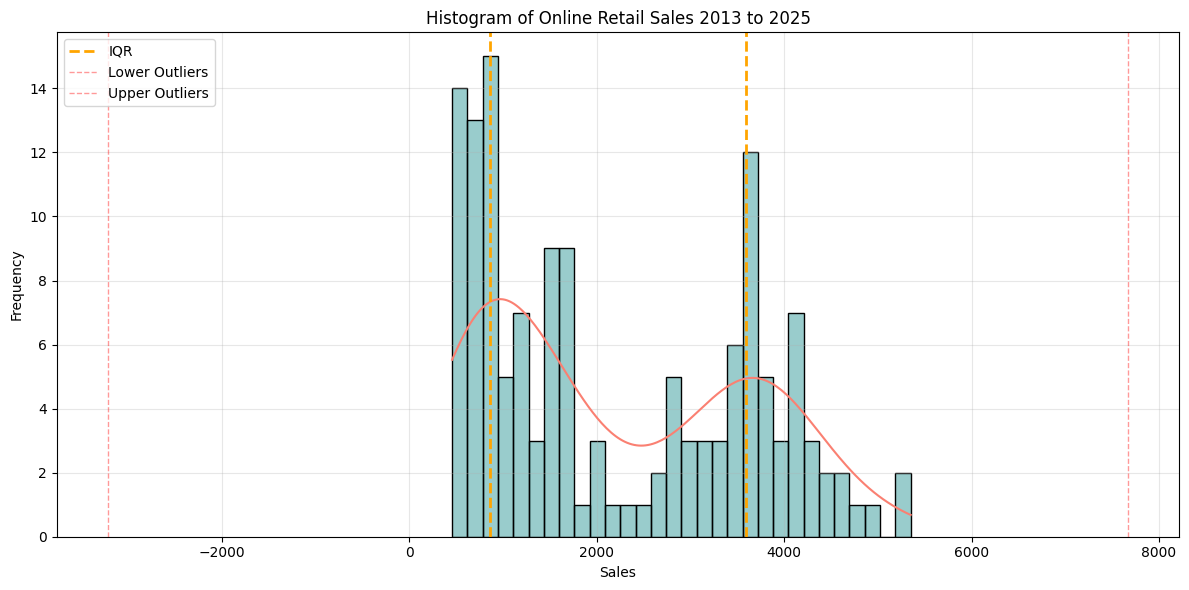

Normality Test Statistic: 103.678
p-value: 0.000000
The distribution is not Normal.


In [286]:
title = 'Histogram of Online Retail Sales 2013 to 2025'
util.pt_histogram(data=data, variable='Sales', title=title)

# Time Series of Original Data:
- Check Seasonality and General Trends.

NOTE: The data was grouped to the end of each Month.

Result: The time-series shows seasonality for each year along with an increasing level (trend) and seasonal variance after each year. Increases in sales seemed to occur during Easter, Mother's Day, End of Financial Year Sale, Father's Day, Black Friday, and Christmas. The seasonality is not perfectly consistent with minor changes for some of the sale periods. During COVID there was a very large increase in sales which changes the seasonal pattern between March 2020 to October in 2021. The sales also showed a very large increase overall during COVID with it doubling by the end of the two years. Although the trend slowed down after COVID, the peak months of November and December continued to see very large increases. Black Friday sales occured in November and overtook Christmas in sales from 2020 to 2023 after which Christmas once again had the highest sales in 2024.

In [287]:
# Sale Dates are created by evaluating the time series spikes and popular sale periods found on: https://www.periscopemedia.co/blog/all-the-ecommerce-sale-dates-in-australia.
# By evaluating the data this way, it was found that the sales numbers were collected for the end of each Month.

# Easter (March): Set just before the Good Friday Sales.
# Mother's Day (May): Occurs in the middle of May and has some significant spikes in the data each year.
# End of Financial Year Sale (June): Occurs just before Tax returns from June to July where we start to see an upward trend each year.
# Father's Day (August): Occurs at the start of September but we see an upward trend just before the month for each year. However it is not as prominent as Mother's Day.
# Black Friday (November): A significant spike in sales which begins to overtake Christmas period sales after COVID.
# Christmas (December): Consistently large sales for each year during the month.
easter = data[data.index.month == 3]
mothers = data[data.index.month == 5]
eof = data[data.index.month == 6]
fathers = data[data.index.month == 8]
black_friday = data[data.index.month == 11]
christmas = data[data.index.month == 12]
seasonal_dates = [
    {'label': 'Easter', 'data': easter, 'color': '#ff7f50'},
    {'label': "Mother's Day", 'data': mothers, 'color': '#66cdaa'},
    {'label': 'EOF Sale', 'data': eof, 'color': '#800080'},
    {'label': "Father's Day", 'data': fathers, 'color': '#468499'},
    {'label': 'Black Friday', 'data': black_friday, 'color': '#0E2F44'},
    {'label': 'Christmas', 'data': christmas, 'color': '#CC0000'}
]

In [288]:
# Highlighting is used for the COVID period where sales begin to change and create different
# patterns in the data.
highlights = [
    {
        'start': data.index[(data.index.year == 2020) & (data.index.month == 3)][0],
        'end': data.index[(data.index.year == 2020) & (data.index.month == 8)][0],
        'color': '#b0e0e6',
        'label': 'March 2020 to August 2020 (COVID Effect)'
    },
    {
        'start': data.index[(data.index.year == 2021) & (data.index.month == 5)][0],
        'end': data.index[(data.index.year == 2021) & (data.index.month == 10)][0],
        'color': "#f1c5cf",
        'label': 'May 2021 to October 2021 (COVID Effect)'
    }
]

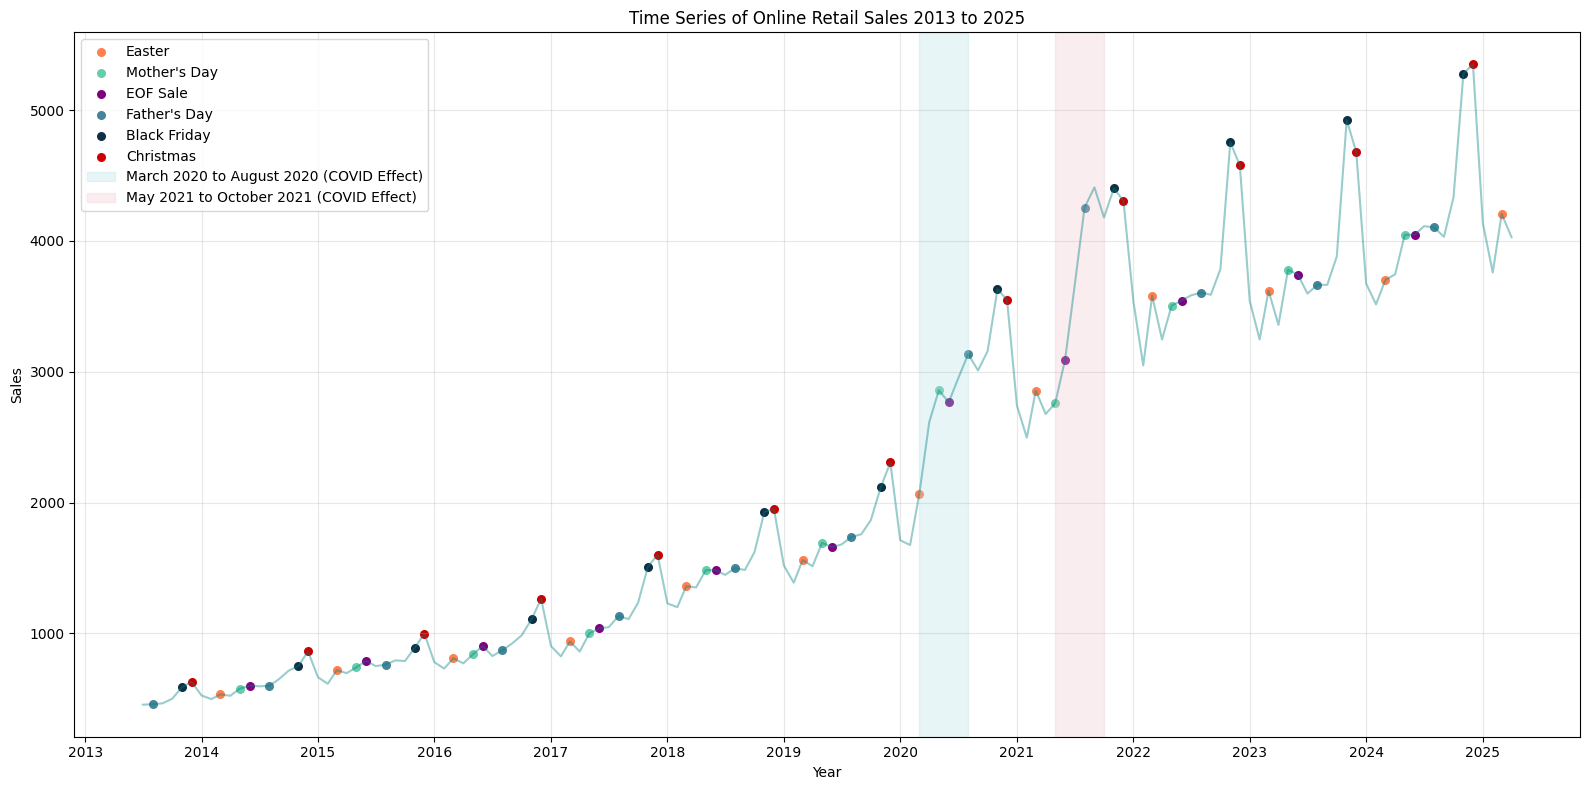

In [289]:
title = 'Time Series of Online Retail Sales 2013 to 2025'
util.pt_time(data=data, variable='Sales', seasonal_dates=seasonal_dates, 
             highlights=highlights, test=None, preds=None, title=title)

# Cumulative Mean and Variance:

Result: Because of the very low variance and mean before COVID, we see the cumulative mean being affected by the low sales in the early period. The variance plot shows the extreme change more clearly indicating a very large increase in variance post-COVID with continous exponential growth. This means that a log transformation is required.

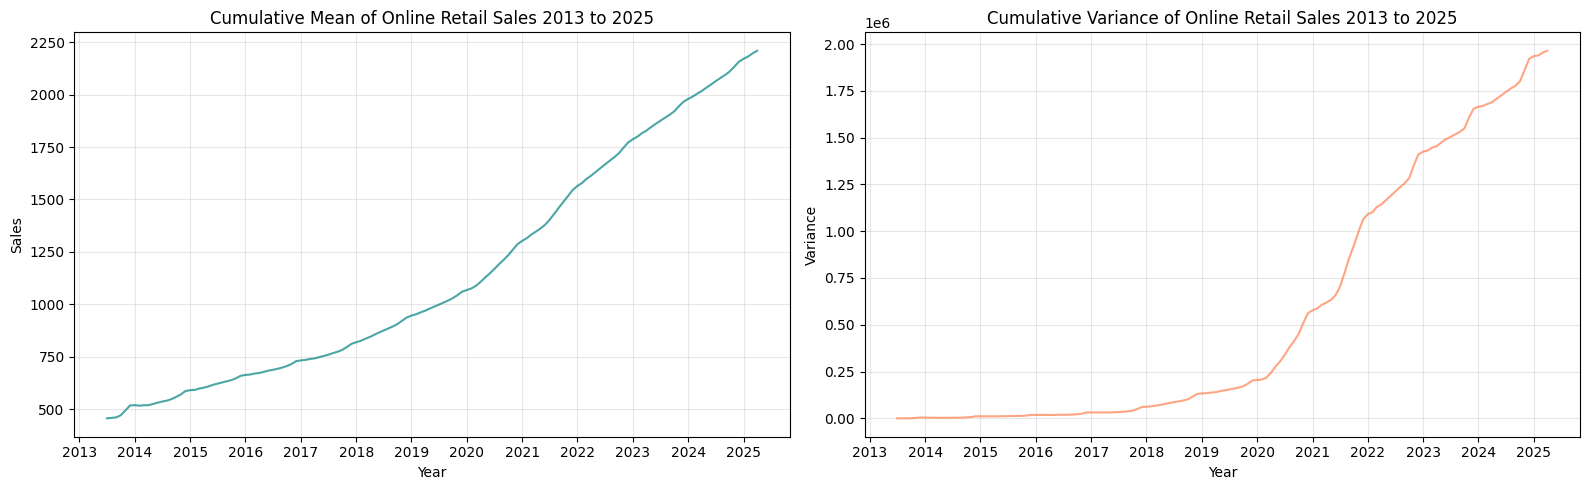

In [12]:
title = 'Online Retail Sales 2013 to 2025'
util.pt_mean_var(data=data, variable='Sales', title=title)

# Preliminary Augmented Dickey-Fuller Test, STL Decomposition and Auto Regression:

Result: The ADF test on the untransformed data indicates the data is non-stationary. After taking the first difference the data becomes stationary. When doing a log transformation the data once again becomes non-stationary (likely due to the seasons). The test also finds that 11-13 lags are optimal in reducing AIC which could be an issue as this falls right upto the COVID period. The STL Decomposition indicates that the log transformation successfully corrected the increasing variance in the seasonal data. The residuals also deviate from the mean around the COVID period (a shock event). The Autocorrelation Function shows a strong seasonal pattern occuring each year with significant lags to the end of the data further validating the use of a SARIMA model (Seasonal ARIMA). The data may also need to be reduced for two reasons, the variance and mean before COVID is much more different to post COVID, and the significant spikes throughout indicate that a very complex model (many lags) could need to be implemented.

These patterns futher validate the need for a few things:

- The increasing variance needs to be addressed with a log transformation.
- The data needs to be differenced (first difference) to be stationary.
- The data has a clear seasonal pattern and requires seasonal differencingl - this helps the model identify patterns outside of the seasons.
- The COVID period could potentially create problems in predictions due to the changing pattern.

An additional transformation which might be required is the length of the overall data. We should have full ending seasons with one season being the test set which requires dropping some months and the year 2013 since the data does not have full cycles for some years. This means after differencing our data should start in April of 2015 so that the final season ends at the most recent date in the data.

ADF Statistic: 1.8158599288853514.
p-value: 0.9840541777389463
Fail to reject the null hypothesis — the series may still be non-stationary.
Critical Value (1%): -2.583
Critical Value (5%): -1.943
Critical Value (10%): -1.615
Lag Value of 13 minimises AIC.

First Differenced Data.
ADF Statistic (1 Difference): -2.5440357204514625
p-value: 0.010603199650743654
Reject the null — the 1 difference is stationary.
Critical Value (1%): -2.583
Critical Value (5%): -1.943
Critical Value (10%): -1.615
Lag Value of 12 minimises AIC.

Log Transformed and First Differenced Data.
ADF Statistic: -1.8087247472679262.
p-value: 0.06704982881349013
Fail to reject the null hypothesis — the series may still be non-stationary.
Critical Value (1%): -2.583
Critical Value (5%): -1.943
Critical Value (10%): -1.615
Lag Value of 11 minimises AIC.


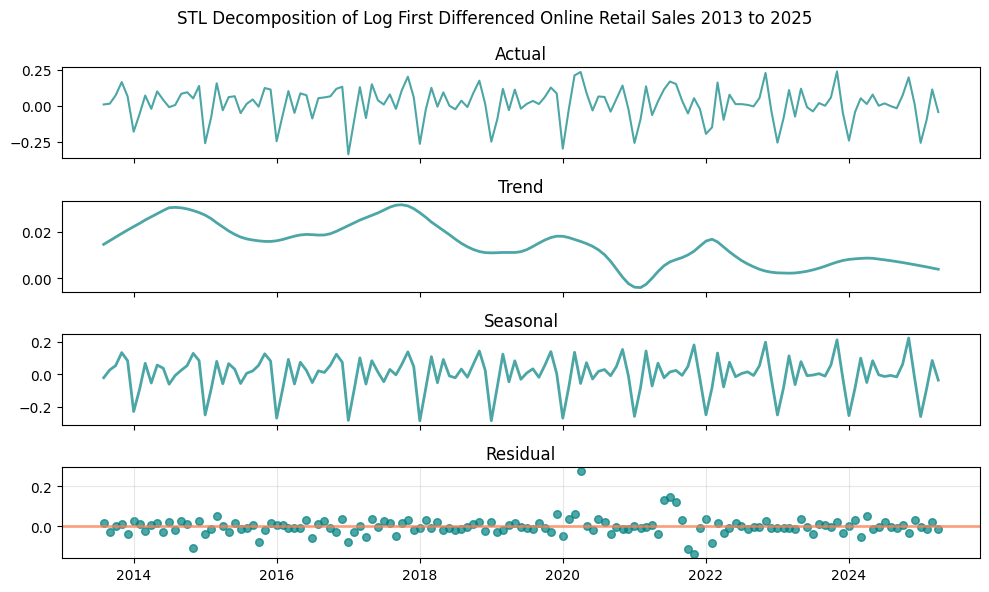

Number of Years in Data: 11.833333333333334


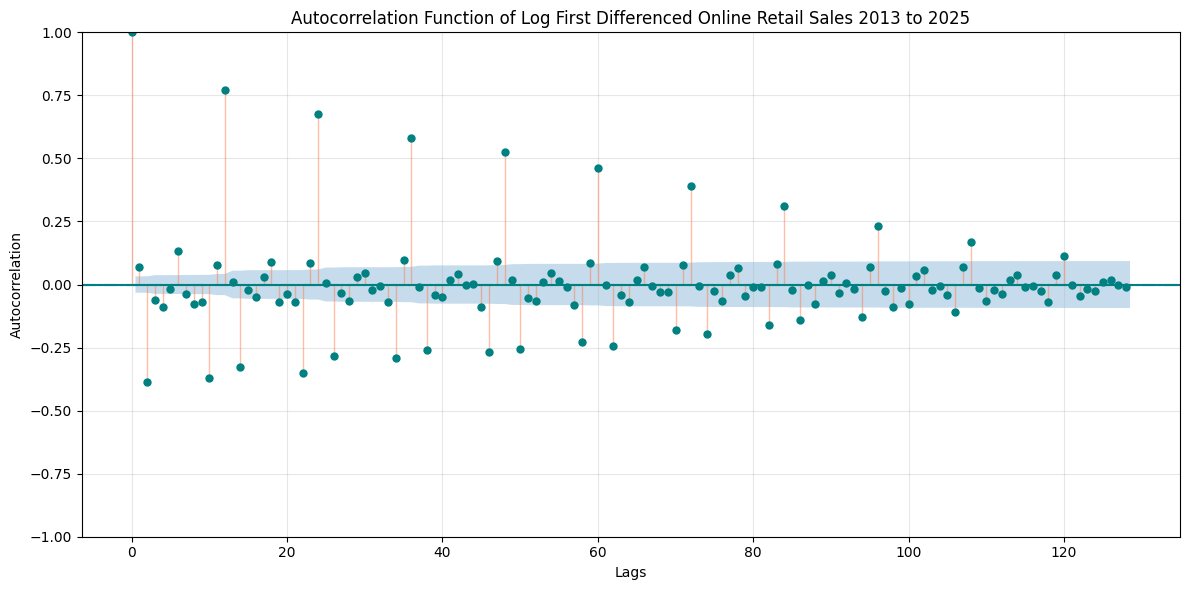

In [291]:
# Check ADF on data.
('Standard Data.')
util.adf_test(data=data, variable='Sales')

print('\nFirst Differenced Data.')
util.adf_test(data=data, variable='Sales', n_diff=1)

# Create copy for Auto Correlation Function Test.
check_data = data.copy()

# Transform data.
check_data = util.transform(data=check_data, variable='Sales', x_log=True, n_diff=1)

# Check ADF after log transformation.
print('\nLog Transformed and First Differenced Data.')
util.adf_test(data=check_data, variable='Sales')

# Plot STL Decomposition.
title = 'STL Decomposition of Log First Differenced Online Retail Sales 2013 to 2025'
util.pt_stl(data=check_data, period=12, variable='Sales', title=title)

# 11.8 Months could disrupt the seasonal 12-step cycle we are trying to capture.
print(f"Number of Years in Data: {len(data)/12}")

# Plot ACF.
title = 'Autocorrelation Function of Log First Differenced Online Retail Sales 2013 to 2025'
util.pt_acf(data=check_data, variable='Sales', lags=128, title=title)

# Seasonal Adjustment Augmented Dickey-Fuller Test, STL Decomposition and Auto Regression:

After preliminary evaluation, the data is transformed for an ARIMA model with seasons pre-defined.

- The data is set to have full 12 month periods so that the seasons are full for each block leading upto the end of the data.
- A log transformation is done to reduce the increasing variance in seasons.
- The first difference is taken to make the data stationary.
- Seasonal difference is taken to focus the model on the changes that occur between seasons.
- Standard scaling is done to make a better fit model and improve training time.

Result: The STL decomposition shows that the variance has been corrected. The trend shows an oscilating pattern and the seasonaal decomposition still indicates some seasonality but it varies from block to block. Residuals show that 2017 deviates slightly from the normal pattern and that the COVID period also deviates comparatively to the rest of the data which could cause some unwanted behaviour in the test predictions (outlier influenced).

In [292]:
# Set the dataset to end as full years to the last date.
data = data[data.index >= '2014-04-01']

Data Length After Transformation: 120
ADF Statistic: -5.252943783287442.
p-value: 3.330111688551924e-07
Reject the null hypothesis — the series is stationary
Critical Value (1%): -2.587
Critical Value (5%): -1.944
Critical Value (10%): -1.615
Lag Value of 12 minimises AIC.


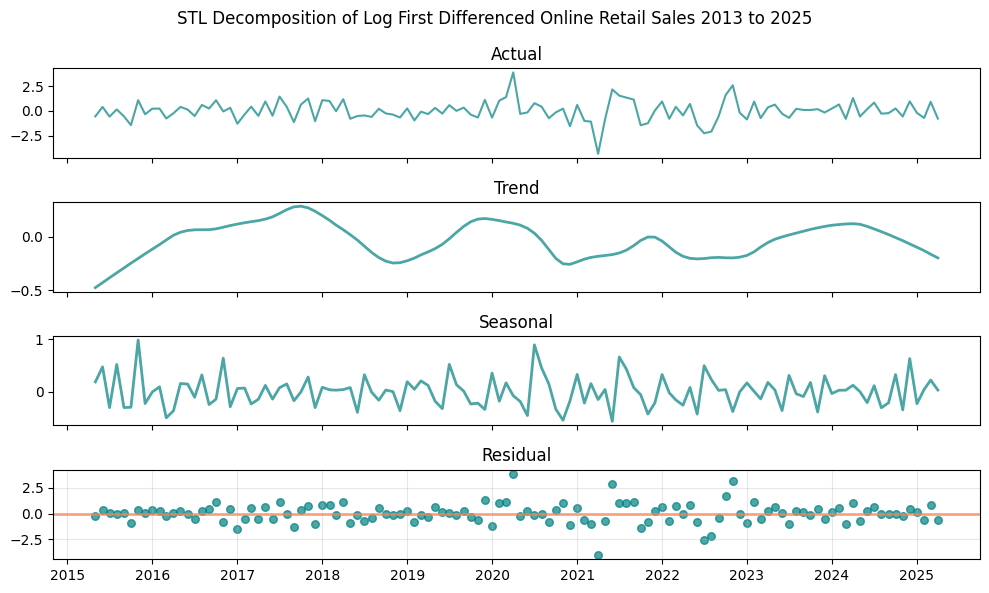

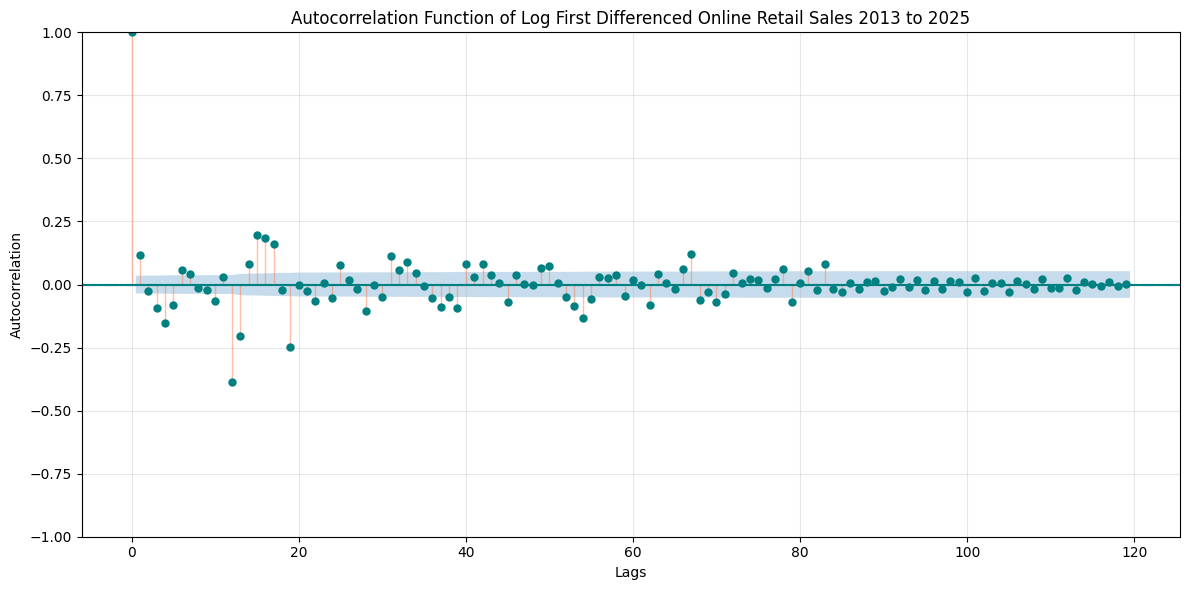

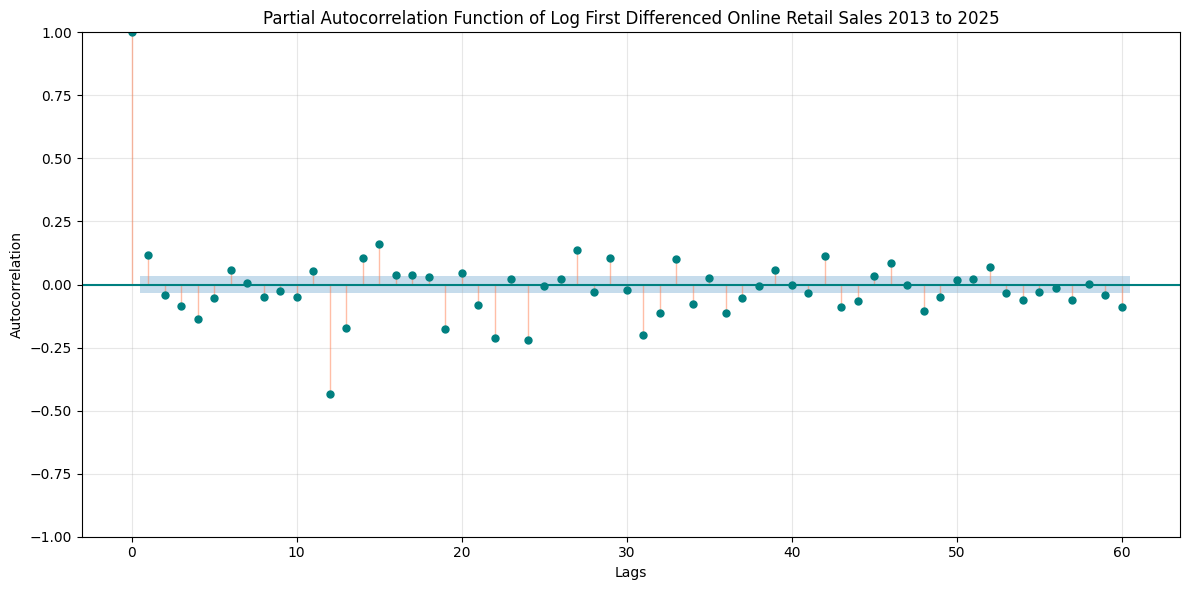

In [293]:
# Make new Utility object.
util = Utility()

# Transform data.
# - Log Transformation.
# - First Difference.
# - Seasonal Difference.
# - Min-max scaling.
data = util.transform(data=data, variable='Sales', x_log=True, n_diff=1, n_season=12, scale='standard')

# Verify length.
print(f"Data Length After Transformation: {len(data)}")

# Evaluate Data.
util.adf_test(data=data, variable='Sales', n_diff=None, reg=None, n_season=None)

# STL Decomposition
title = 'STL Decomposition of Log First Differenced Online Retail Sales 2013 to 2025'
util.pt_stl(data=data, variable='Sales', period=None, title=title)

# Plot ACF.
title = 'Autocorrelation Function of Log First Differenced Online Retail Sales 2013 to 2025'
util.pt_acf(data=data, variable='Sales', lags=119, title=title)

# Plot PACF.
title = 'Partial Autocorrelation Function of Log First Differenced Online Retail Sales 2013 to 2025'
util.pt_acf(data=data, variable='Sales', type_of='partial', lags=60, title=title)

# Grid Search for Optimal ARIMA parameters (Autocorrelation and Moving Average):

Result: The grid search indicates that the best model is an ARIMA with low lags particularly for Autocorrelation. This gives us a hint that the model may overfit with large number of lags but is not indicative of the actual optimal parameters which should be evaluated further with Ljun-Box test, Mean Squared Percentage Error, and Residual fit along with visualisations. The reason we get this result could be that the preceding season for the predicted season highly resembles it.

In [294]:
# Grid search ARIMA.
util.grid_search_sarima(data=data, variable='Sales', ar=12, ma=12, print_limit=10)

Fitting models: 100%|██████████| 144/144 [00:58<00:00,  2.45it/s]

    (p,q)         AIC
0  (0, 0)  342.545248
1  (0, 1)  342.754943
2  (0, 2)  344.735636
3  (0, 3)  346.259977
4  (0, 4)  345.916252
5  (0, 5)  345.052769
6  (0, 6)  345.575288
7  (0, 7)  346.992966
8  (0, 8)  346.729052
9  (0, 9)  348.467492


# Model Prediction and Evaluation:

Two models are compared for forecasts over one year and two year periods. An ARIMA model with no lags and one with Autoregression lag of 1 and Moving Average lag of 12.

- The data is split into train and test set where the test set is the last season (year) ending in April 2025.
- The ARIMA model is set to optimal parameters after evaluating the Ljun-Box test, Mean Absolute Percentage Error.
- The differenced parameters have been pre-processed and are ommited in the actual model.

Result: The Model showed a reasonably good fit except for one residual. The Ljun-Box test indicated that for the first 13 lags the model has successfully captured the patterns in the data and that it becomes more evident in the later lags.

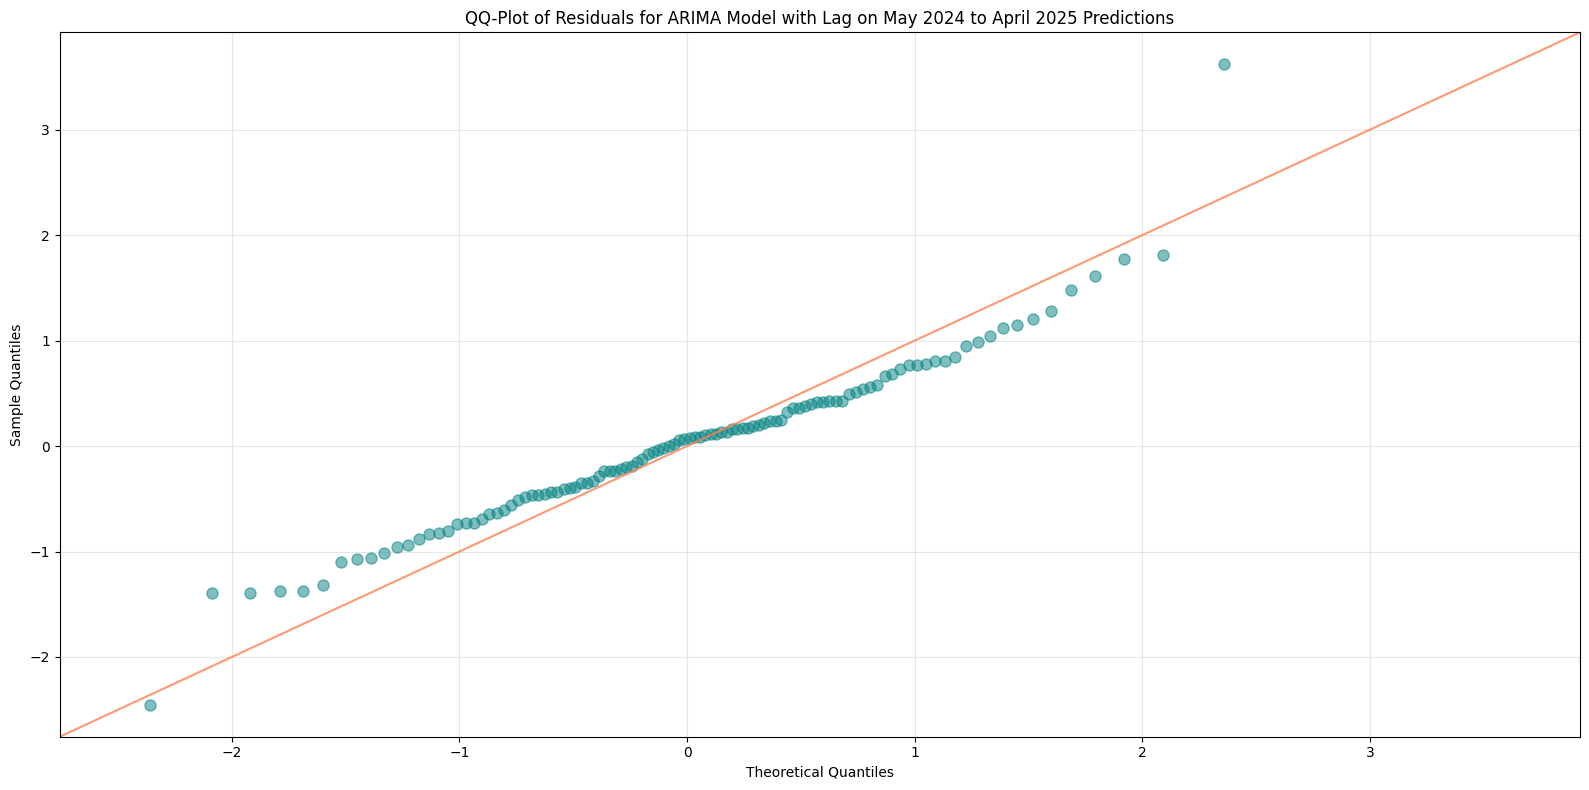

     lb_stat  lb_pvalue
1   0.196212   0.657796
2   2.555696   0.278636
3   3.089710   0.377999
4   3.962108   0.411158
5   4.757387   0.446201
6   4.823371   0.566659
7   5.177249   0.638343
8   5.258248   0.729651
9   5.814665   0.758315
10  5.846383   0.828000
11  5.858487   0.882637
12  6.158471   0.907884
13  7.607781   0.868181


In [295]:
# Create train and test set. Test set is last full season (1-year).
split_date = '2024-05-01'
train = data[data.index < split_date]
test = data[data.index >= split_date]

# Set parameters and initialise ARIMA model.
model1 = SARIMAX(
    train['Sales'],
    order=(1, 0, 12),
    seasonal_order=(0, 0, 0, 0),
    simple_differencing=False
)

# Fit first model with lag.
model1_fit = model1.fit(disp=False)

# Predict test set.
forecast1 = model1_fit.forecast(steps=len(test))

# Test prediction residuals.
residuals1 = model1_fit.resid

# Plot residuals on QQ-plot and print Ljun-Box test for first 10 lags.
title = 'QQ-Plot of Residuals for ARIMA Model with Lag on May 2024 to April 2025 Predictions'
util.pt_model_fit(residuals=residuals1, title=title, lj_lags=13)


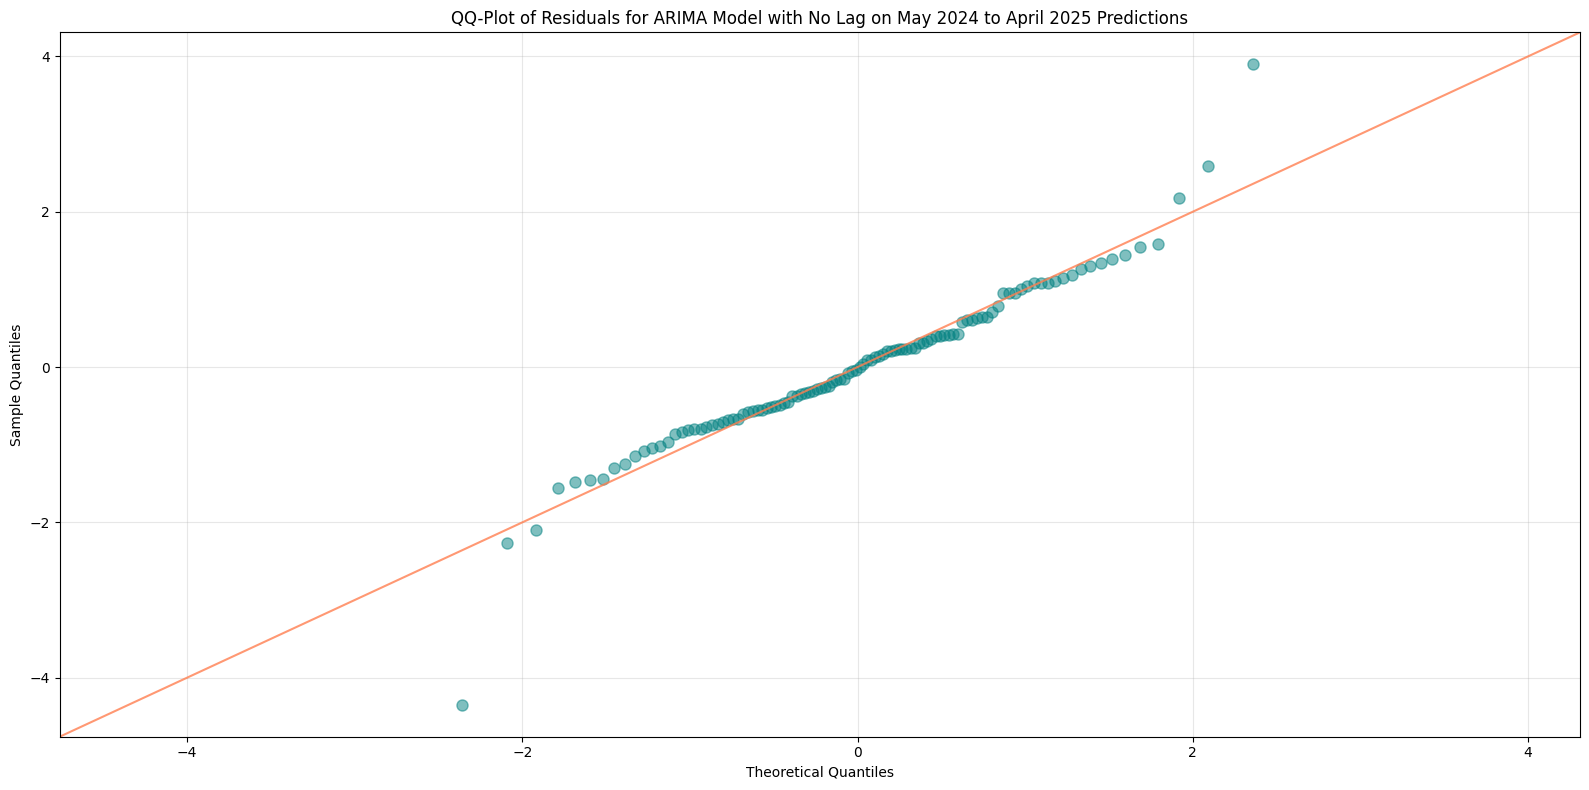

      lb_stat  lb_pvalue
1    2.487734   0.114737
2    2.571018   0.276510
3    4.067383   0.254279
4    6.122021   0.190219
5    7.299530   0.199300
6    7.636398   0.265970
7    8.174628   0.317448
8    8.372674   0.397938
9    8.381049   0.496248
10   8.871567   0.544334
11   8.878166   0.633137
12  25.991704   0.010763
13  32.102784   0.002319


In [296]:
# Set parameters and initialise ARIMA model.
model2 = SARIMAX(
    train['Sales'],
    order=(0, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    simple_differencing=False
)

# Fit second model - no lag.
model2_fit = model2.fit(disp=False)

# Predict test set.
forecast2 = model2_fit.forecast(steps=len(test))

# Test prediction residuals.
residuals2 = model2_fit.resid

# Plot residuals on QQ-plot and print Ljun-Box test for first 10 lags.
title = 'QQ-Plot of Residuals for ARIMA Model with No Lag on May 2024 to April 2025 Predictions'
util.pt_model_fit(residuals=residuals2, title=title, lj_lags=13)

# Visualisations and Evaluations for Predictions (1 Year):

Result: The time-series shows good results for the ARIMA Models. Overall the prediction for ARIMA is better than the naive predictions. For Naive methods the mean had just over 50 % accuracy whilst Naive Last Value, Seasonal, and Drift had better results. Drift was the best Naive prediction as it was able to predict the growth of the test set based on the slope. When comparing the two ARIMA Models we see that the one with no lag had a better prediction. This is because the lag term influences how strongly the past data should affect the predictions. The ARIMA model with lag is influenced more by data before 2023 and since there is a change it patter, it has a negative impact on accuracy. This reveals that by shortening the lag term, we can reduce this effect.

The percentage accuracy for the predictions based on Mean Absolute Square Error are:

- ARIMA with Lag: 96.73 %
- ARIMA with No Lag: 97.56 %
- Naive Mean: 50.22 %
- Naive Last Value: 88.33 %
- Naive Seasonal: 86.52 %
- Naive Drift: 91.69 %

The highlighted section in the time-series shows that in the same blocks that we see a large increase during the COVID period, that the predicted block is also increased for the ARIMA Model with lag. This could potentially be reduced by interpolating that section with a slope.

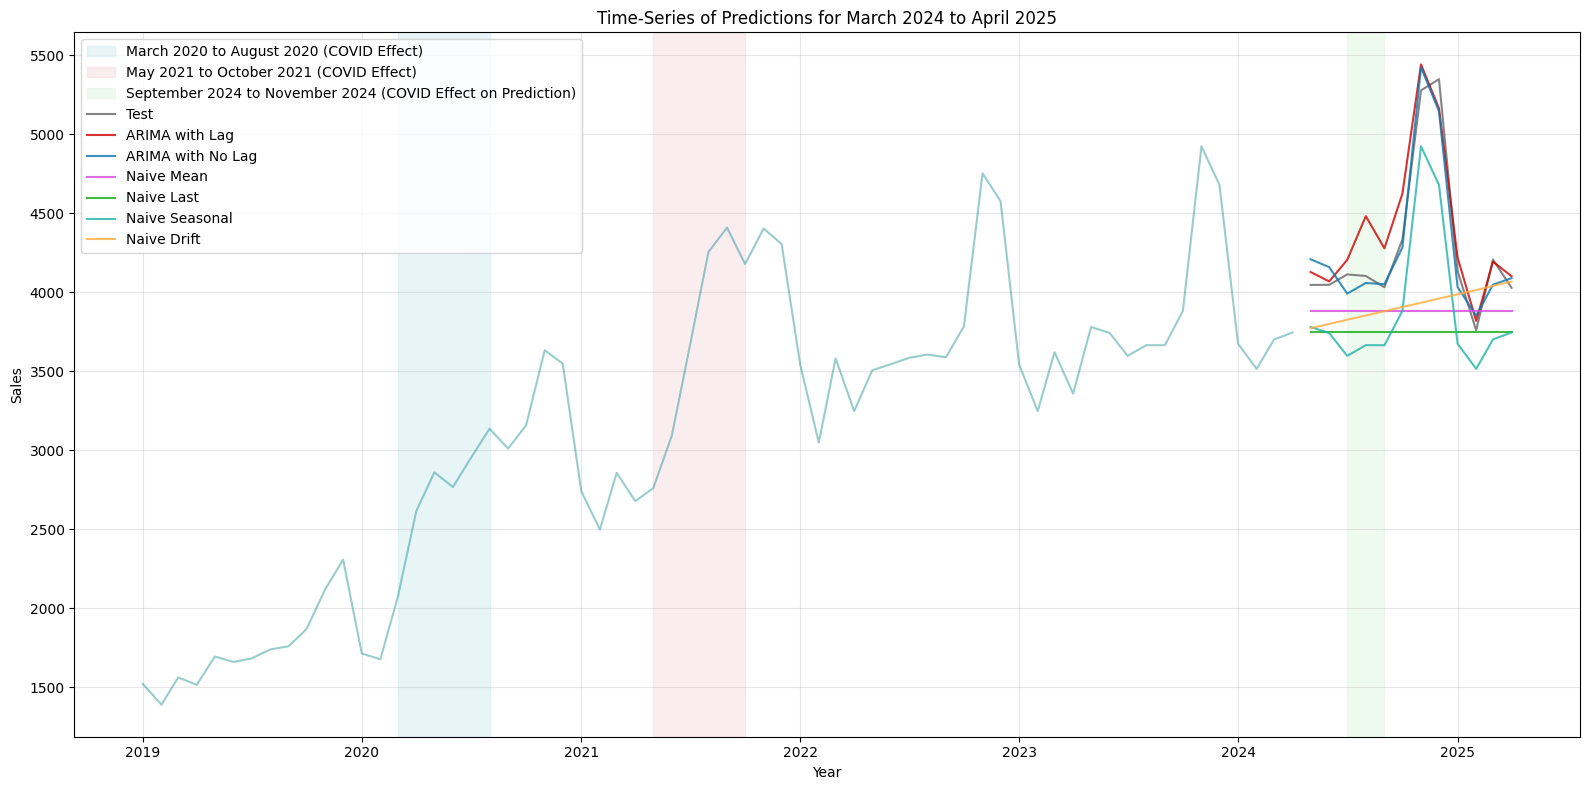

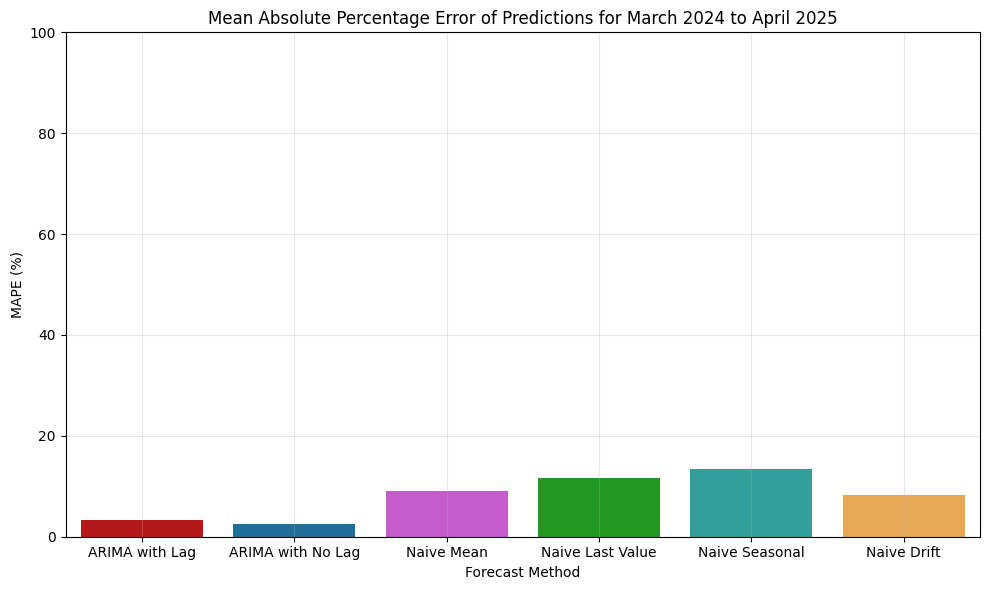

Mean Absolute Percentage Error for ARIMA with Lag: 3.269
Mean Absolute Percentage Error for ARIMA with No Lag: 2.437
Mean Absolute Percentage Error for Naive Mean: 9.016
Mean Absolute Percentage Error for Naive Last Value: 11.669
Mean Absolute Percentage Error for Naive Seasonal: 13.479
Mean Absolute Percentage Error for Naive Drift: 8.314


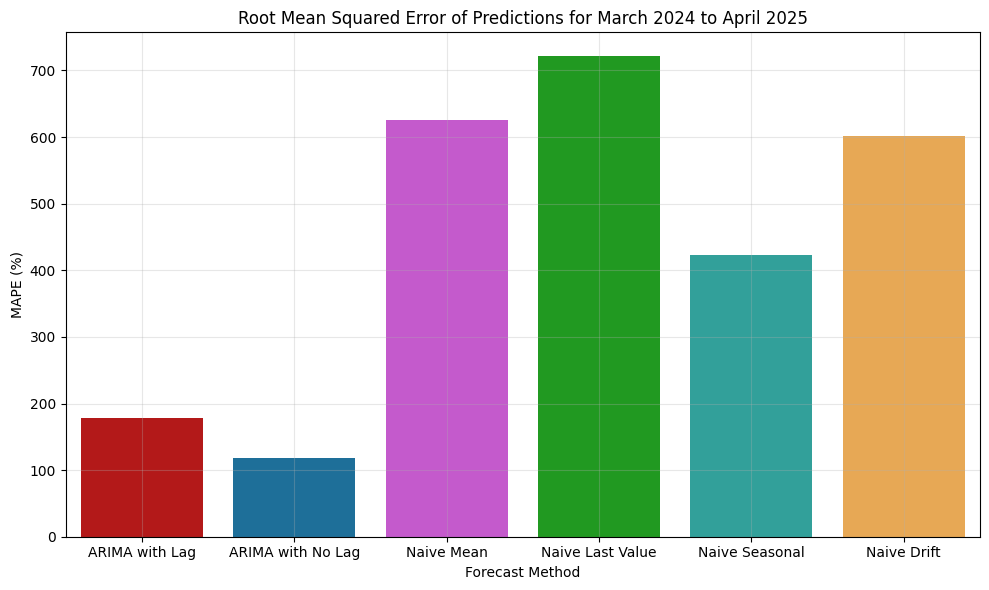

Root Mean Squared Error for ARIMA with Lag: 178.423
Root Mean Squared Error for ARIMA with No Lag: 118.754
Root Mean Squared Error for Naive Mean: 626.135
Root Mean Squared Error for Naive Last Value: 721.18
Root Mean Squared Error for Naive Seasonal: 422.608
Root Mean Squared Error for Naive Drift: 601.615


In [297]:
# The data is reconstructed to its original form (inverse transformed) with the train and test set.
# Create DataFrame with predictions.
dates = test.index
forecast1 = pd.DataFrame({'Sales': forecast1.values}, index=dates)
forecast2 = pd.DataFrame({'Sales': forecast2.values}, index=dates)

# Concatenate data back before transformations.
x1 = pd.concat([train, forecast1])
x2 = pd.concat([train, forecast2])
x3= pd.concat([train, test])

# Inverse transformation.
x1 = util.inverse_transform(x1)
x2 = util.inverse_transform(x2)
x3 = util.inverse_transform(x3)

# Lag.
train = x1[x1.index < split_date]
pred_model1 = x1[x1.index >= split_date]
# No lag.
train = x2[x2.index < split_date]
pred_model2 = x2[x2.index >= split_date]
# Test set.
test = x3[x3.index >= split_date]

# Get naive predictions.
pred_mean = util.get_naive_preds(train=train, variable='Sales', test=test, type_of='mean')
pred_last = util.get_naive_preds(train=train, variable='Sales', test=test, type_of='last')
pred_season = util.get_naive_preds(train=train, variable='Sales', test=test, type_of='season')
pred_drift = util.get_naive_preds(train=train, variable='Sales', test=test, type_of='drift')

# Create dictionary of predictions.
preds = [
    {
        'data': pred_model1['Sales'],
        'color': '#CC0000',
        'label': 'ARIMA with Lag'
    },
    {
        'data': pred_model2['Sales'],
        'color': '#0a75ad',
        'label': 'ARIMA with No Lag'
    },
    {
        'data': pred_mean,
        'color': "#d547df",
        'label': 'Naive Mean'
    },
    {
        'data': pred_last,
        'color': '#0DAD0D',
        'label': 'Naive Last'
    },
    {
        'data': pred_season,
        'color': '#20b2aa',
        'label': 'Naive Seasonal'
    },
    {
        'data': pred_drift,
        'color': '#ffab3d',
        'label': 'Naive Drift'
    }
]

# Create dictionary of highlights.
highlights = [
    {
        'start': data.index[(data.index.year == 2020) & (data.index.month == 3)][0],
        'end': data.index[(data.index.year == 2020) & (data.index.month == 8)][0],
        'color': '#b0e0e6',
        'label': 'March 2020 to August 2020 (COVID Effect)'
    },
    {
        'start': data.index[(data.index.year == 2021) & (data.index.month == 5)][0],
        'end': data.index[(data.index.year == 2021) & (data.index.month == 10)][0],
        'color': "#f1c5cf",
        'label': 'May 2021 to October 2021 (COVID Effect)'
    },
    {
        'start': data.index[(data.index.year == 2024) & (data.index.month == 9)][0],
        'end': data.index[(data.index.year == 2024) & (data.index.month == 7)][0],
        'color': "#cdf0cd",
        'label': 'September 2024 to November 2024 (COVID Effect on Prediction)'
    }
]

# Reduce data to after 2019 for clearer visualisation.
train = train[train.index.year >= 2019]

# Plot predictions.
title = 'Time-Series of Predictions for March 2024 to April 2025'
util.pt_time(data=train, variable='Sales', highlights=highlights, test=test, preds=preds, title=title)

# Calculate MAPE for predictions.
m_model1 = util.get_mape(y_true=test, y_pred=pred_model1)
m_model2 = util.get_mape(y_true=test, y_pred=pred_model2)
m_mean = util.get_mape(y_true=test.values, y_pred=pred_mean)
m_last = util.get_mape(y_true=test.values, y_pred=pred_last)
m_season = util.get_mape(y_true=test.values, y_pred=pred_season)
m_drift = util.get_mape(y_true=test.values, y_pred=pred_drift)

# Add predictions to dictionary.
mape_result = [
    {
        'label': 'ARIMA with Lag',
        'result': m_model1,
        'color': '#CC0000'
    },
    {
        'label': 'ARIMA with No Lag',
        'result': m_model2,
        'color': '#0a75ad'
    },
    {
        'label': 'Naive Mean',
        'result': m_mean,
        'color': '#d547df'
    },
    {
        'label': 'Naive Last Value',
        'result': m_last,
        'color': "#0DAD0D"
    },
    {
        'label': 'Naive Seasonal',
        'result': m_season,
        'color': '#20b2aa'
    },
    {
        'label': 'Naive Drift',
        'result': m_drift,
        'color': "#ffab3d"
    }
]

# Plot MAPE Results.
title = 'Mean Absolute Percentage Error of Predictions for March 2024 to April 2025'
util.pt_preds(preds=mape_result, title=title, type_of='mape')

# Calculate MAPE for predictions.
r_model1 = util.get_rmse(y_true=test, y_pred=pred_model1)
r_model2 = util.get_rmse(y_true=test, y_pred=pred_model2)
r_mean = util.get_rmse(y_true=test.values, y_pred=pred_mean)
r_last = util.get_rmse(y_true=test.values, y_pred=pred_last)
r_season = util.get_rmse(y_true=test.values, y_pred=pred_season)
r_drift = util.get_rmse(y_true=test.values, y_pred=pred_drift)

# Add predictions to dictionary.
rmse_result = [
    {
        'label': 'ARIMA with Lag',
        'result': r_model1,
        'color': '#CC0000'
    },
    {
        'label': 'ARIMA with No Lag',
        'result': r_model2,
        'color': '#0a75ad'
    },
    {
        'label': 'Naive Mean',
        'result': r_mean,
        'color': '#d547df'
    },
    {
        'label': 'Naive Last Value',
        'result': r_last,
        'color': "#0DAD0D"
    },
    {
        'label': 'Naive Seasonal',
        'result': r_season,
        'color': '#20b2aa'
    },
    {
        'label': 'Naive Drift',
        'result': r_drift,
        'color': "#ffab3d"
    }
]

# Plot MAPE Results.
title = 'Root Mean Squared Error of Predictions for March 2024 to April 2025'
util.pt_preds(preds=rmse_result, title=title, type_of='rmse')

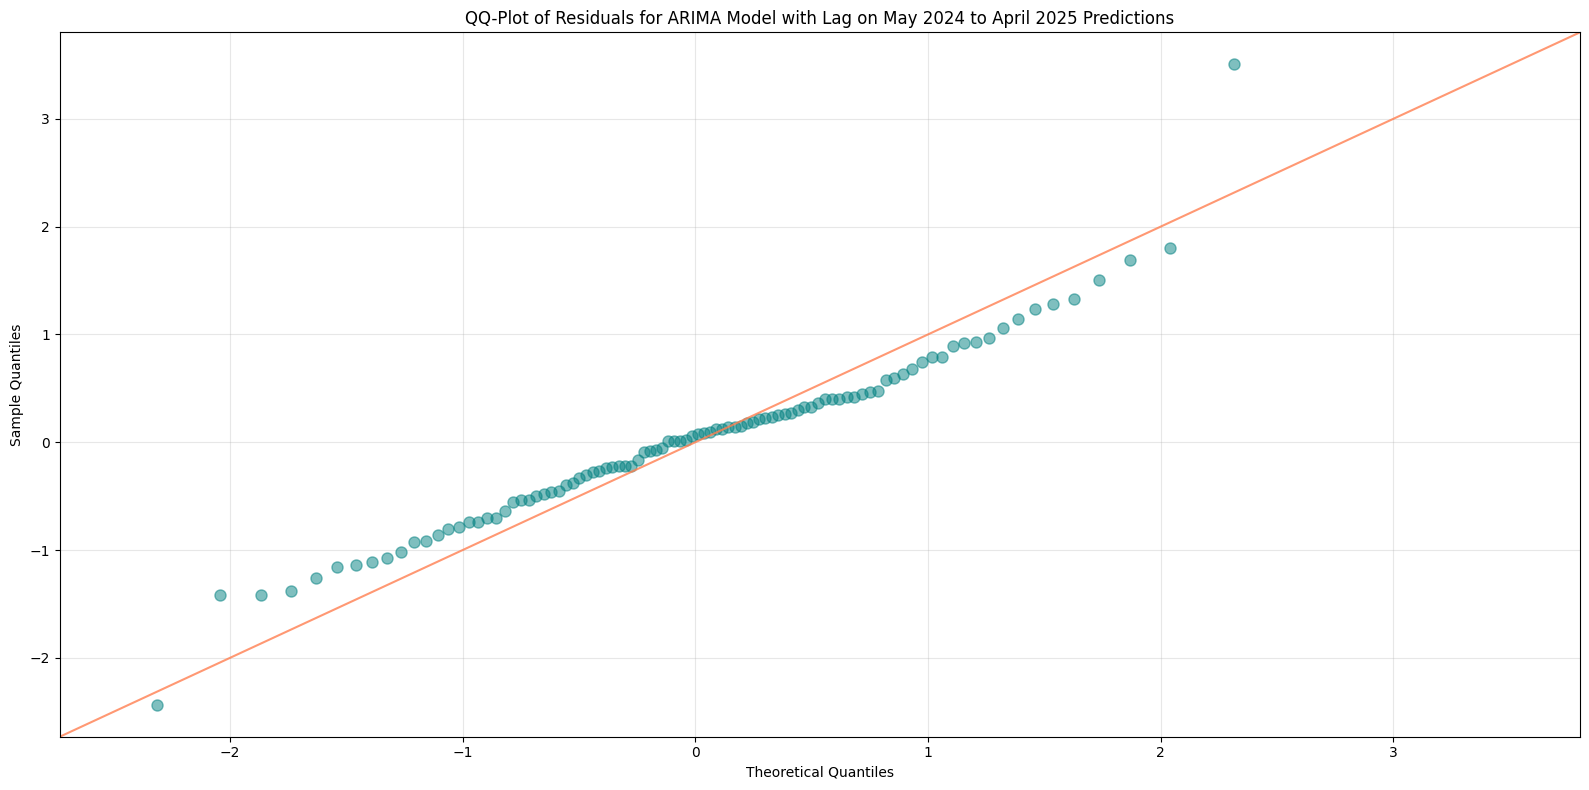

     lb_stat  lb_pvalue
1   0.113410   0.736295
2   1.998344   0.368184
3   2.479481   0.479011
4   3.483569   0.480381
5   4.790485   0.441981
6   4.858460   0.562091
7   5.209456   0.634419
8   5.210295   0.734881
9   5.346617   0.803107
10  5.352741   0.866404
11  5.352863   0.912881
12  7.091677   0.851496
13  8.354725   0.819747


In [298]:
# Create train and test set. Test set is last full season (1-year).
split_date = '2023-05-01'
train = data[data.index < split_date]
test = data[data.index >= split_date]

# Set parameters and initialise ARIMA model.
model1 = SARIMAX(
    train['Sales'],
    order=(1, 0, 12),
    seasonal_order=(0, 0, 0, 0),
    simple_differencing=False
)

# Fit first model with lag.
model1_fit = model1.fit(disp=False)

# Predict test set.
forecast1 = model1_fit.forecast(steps=len(test))

# Test prediction residuals.
residuals1 = model1_fit.resid

# Plot residuals on QQ-plot and print Ljun-Box test for first 10 lags.
title = 'QQ-Plot of Residuals for ARIMA Model with Lag on May 2024 to April 2025 Predictions'
util.pt_model_fit(residuals=residuals1, title=title, lj_lags=13)

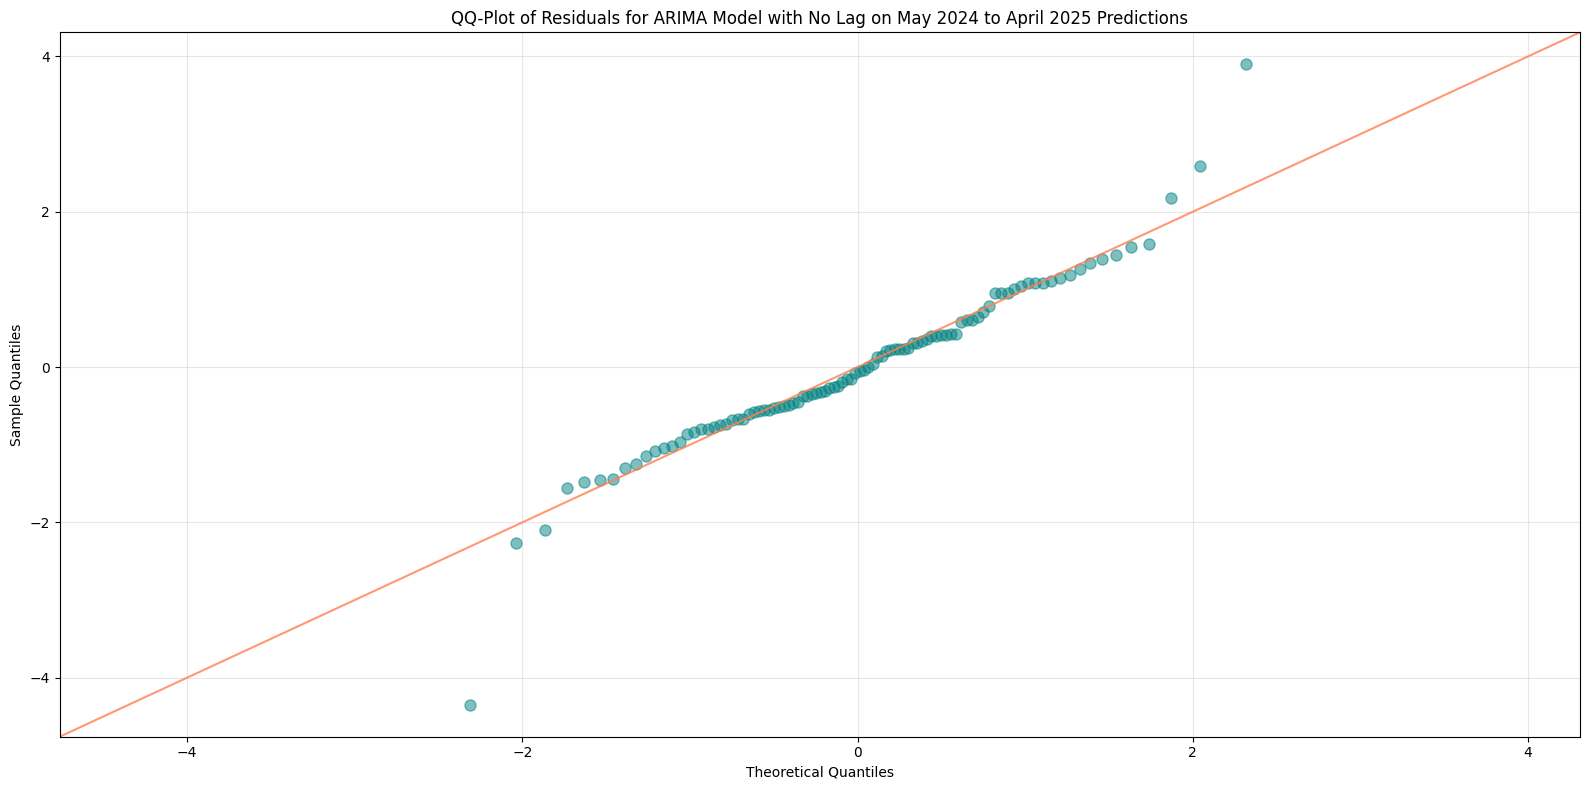

      lb_stat  lb_pvalue
1    2.761220   0.096575
2    2.816020   0.244630
3    4.525072   0.210065
4    6.343096   0.174949
5    7.418739   0.191314
6    7.524569   0.275043
7    8.087852   0.324911
8    8.150006   0.418956
9    8.155418   0.518563
10   8.504216   0.579710
11   8.512321   0.666808
12  28.390184   0.004849
13  33.141818   0.001622


In [299]:
# Set parameters and initialise ARIMA model.
model2 = SARIMAX(
    train['Sales'],
    order=(0, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    simple_differencing=False
)

# Fit second model - no lag.
model2_fit = model2.fit(disp=False)

# Predict test set.
forecast2 = model2_fit.forecast(steps=len(test))

# Test prediction residuals.
residuals2 = model2_fit.resid

# Plot residuals on QQ-plot and print Ljun-Box test for first 10 lags.
title = 'QQ-Plot of Residuals for ARIMA Model with No Lag on May 2024 to April 2025 Predictions'
util.pt_model_fit(residuals=residuals2, title=title, lj_lags=13)

# Visualisations and Evaluations for Predictions (2 Years):

When trying to predict for an extended period, we see that the ARIMA model with no lag decreases in perfomance. It fails to capture the overall trending pattern and looks more like a naive seasonal prediction. The ARIMA model with lag is quite similar in that it projects a very similar shape for both years but it effectively increases with the trend but it is still impacted negatively in the pattern found the COVID period where it forecasts a higher peak in the early years. This concept becomes particularly important if the data that was collected was daily as it would directly impact the amount of steps and lag that influence the forecast.

The resulting MAPE predictions show a decrease in accuracy for the ARIMA with no lag:

- ARIMA with Lag: 96.42 %
- ARIMA with No Lag: 93.17 %

This might not mean much percentage wise but when we look at the Root Mean Squared Error we see that the forecast is incorrect by 175.01 million sales for the ARIMA with Lag and 357.84 million sales for the ARIMA with No Lag.

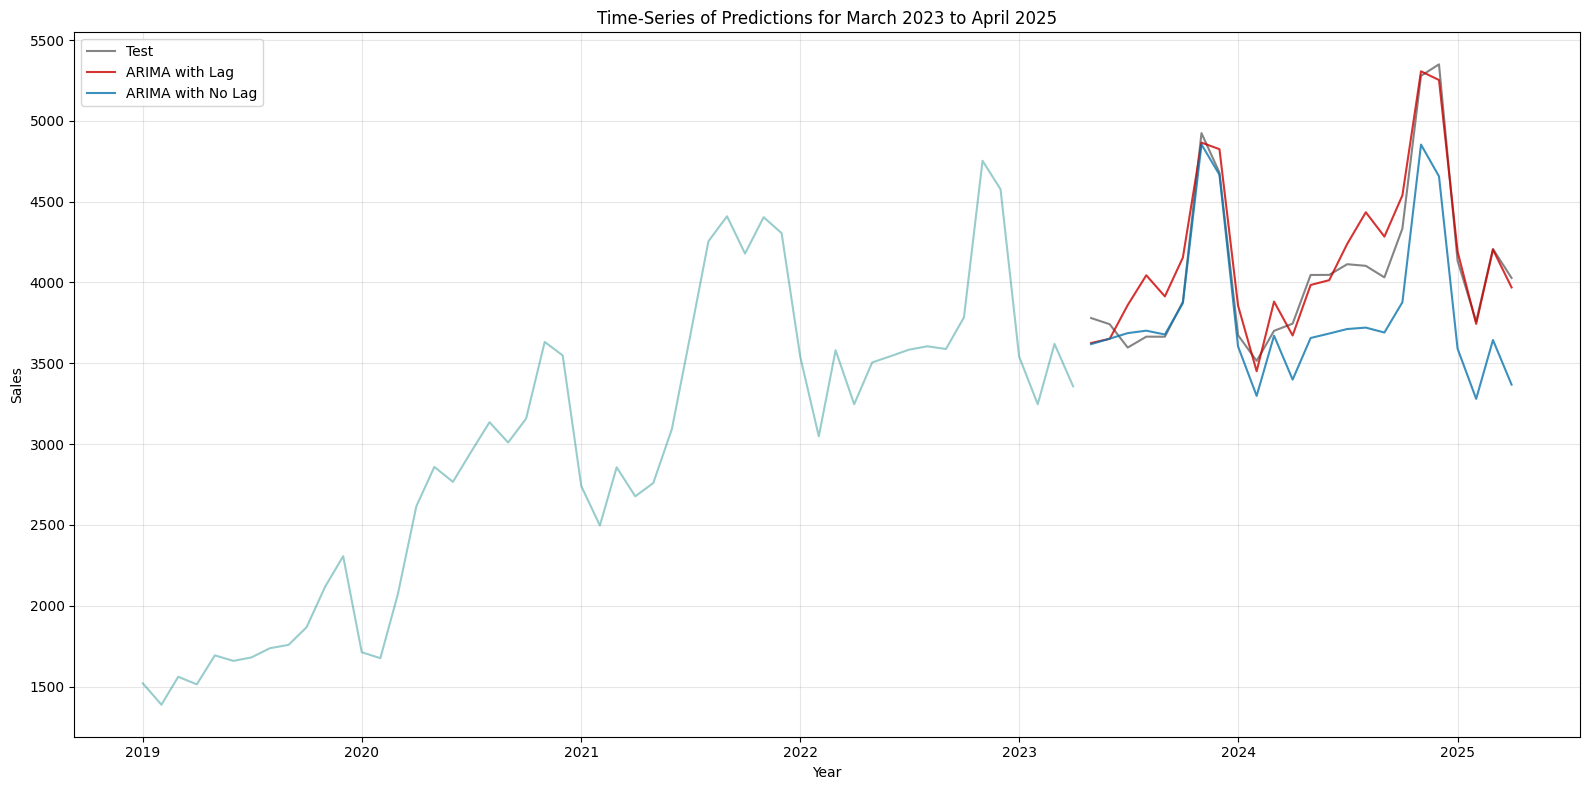

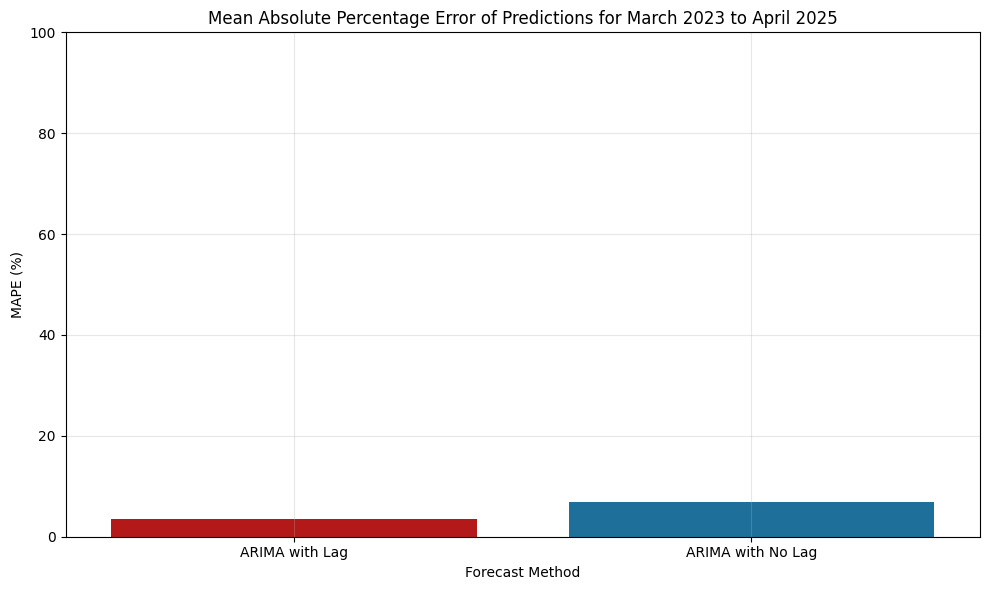

Mean Absolute Percentage Error for ARIMA with Lag: 3.585
Mean Absolute Percentage Error for ARIMA with No Lag: 6.828


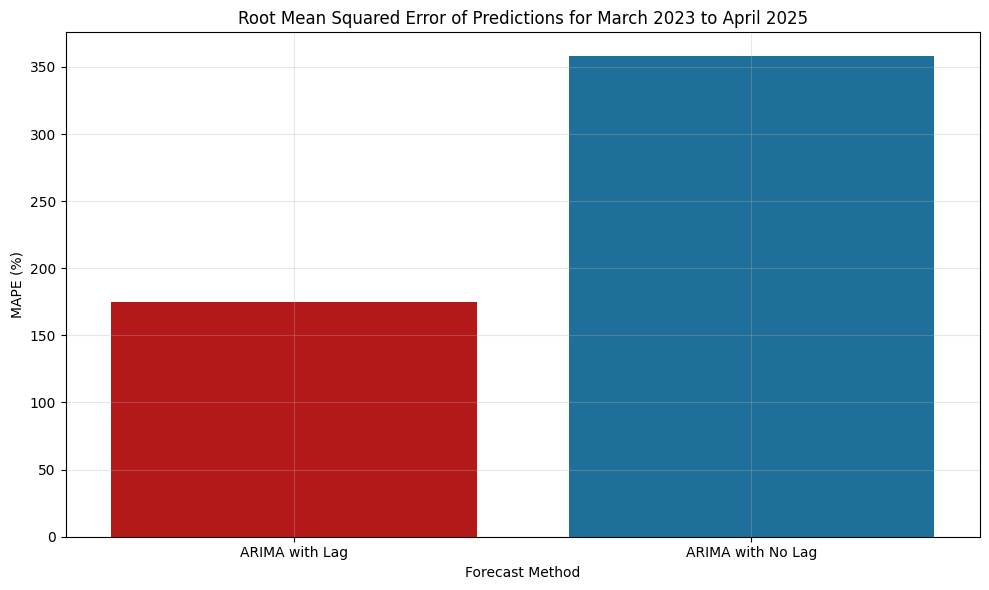

Root Mean Squared Error for ARIMA with Lag: 175.01
Root Mean Squared Error for ARIMA with No Lag: 357.844


In [300]:
# The data is reconstructed to its original form (inverse transformed) with the train and test set.
# Create DataFrame with predictions.
dates = test.index
forecast1 = pd.DataFrame({'Sales': forecast1.values}, index=dates)
forecast2 = pd.DataFrame({'Sales': forecast2.values}, index=dates)

# Concatenate data back before transformations.
x1 = pd.concat([train, forecast1])
x2 = pd.concat([train, forecast2])
x3= pd.concat([train, test])

# Inverse transformation.
x1 = util.inverse_transform(x1)
x2 = util.inverse_transform(x2)
x3 = util.inverse_transform(x3)

# Lag.
train = x1[x1.index < split_date]
pred_model1 = x1[x1.index >= split_date]
# No lag.
train = x2[x2.index < split_date]
pred_model2 = x2[x2.index >= split_date]
# Test set.
test = x3[x3.index >= split_date]

# Create dictionary of predictions.
preds = [
    {
        'data': pred_model1['Sales'],
        'color': '#CC0000',
        'label': 'ARIMA with Lag'
    },
    {
        'data': pred_model2['Sales'],
        'color': '#0a75ad',
        'label': 'ARIMA with No Lag'
    }
]

# Reduce data to after 2019 for clearer visualisation.
train = train[train.index.year >= 2019]

# Plot predictions.
title = 'Time-Series of Predictions for March 2023 to April 2025'
util.pt_time(data=train, variable='Sales', test=test, preds=preds, title=title)

# Calculate MAPE for predictions.
m_model1 = util.get_mape(y_true=test, y_pred=pred_model1)
m_model2 = util.get_mape(y_true=test, y_pred=pred_model2)

# Add predictions to dictionary.
mape_result = [
    {
        'label': 'ARIMA with Lag',
        'result': m_model1,
        'color': '#CC0000'
    },
    {
        'label': 'ARIMA with No Lag',
        'result': m_model2,
        'color': '#0a75ad'
    }
]

# Plot MAPE Results.
title = 'Mean Absolute Percentage Error of Predictions for March 2023 to April 2025'
util.pt_preds(preds=mape_result, title=title, type_of='mape')

# Calculate MAPE for predictions.
r_model1 = util.get_rmse(y_true=test, y_pred=pred_model1)
r_model2 = util.get_rmse(y_true=test, y_pred=pred_model2)

# Add predictions to dictionary.
rmse_result = [
    {
        'label': 'ARIMA with Lag',
        'result': r_model1,
        'color': '#CC0000'
    },
    {
        'label': 'ARIMA with No Lag',
        'result': r_model2,
        'color': '#0a75ad'
    }
]

# Plot MAPE Results.
title = 'Root Mean Squared Error of Predictions for March 2023 to April 2025'
util.pt_preds(preds=rmse_result, title=title, type_of='rmse')

# Interpolation of COVID Period:

An additional pipeline is created to evaluate the effect of interpolating the COVID period with the slope. The goal is to try and decrease the effect seen in the large increase on the following year in the test predictions for that period.

In [306]:
# Import data.
data = pd.read_csv('OnlineRetailTurnover.csv', skiprows=8, header=None, names=['Date', 'Sales'])
# Set Date as index.
data['Date'] = pd.to_datetime(data['Date'], format='%b-%Y')
data = data.set_index('Date')

# Make new Utility object.
util = Utility()

# Set the dataset to end as full years to the last date.
data = data[data.index >= '2014-04-01']

# Interpolate COVID Period with slope.
dates = [2019, 2020, 2021, 2022]
data = util.interpolate(data=data, variable='Sales', years=dates, type_of='seasonal_growth')

# Transform data.
data = util.transform(data=data, variable='Sales', x_log=True, n_diff=1, n_season=12, scale='standard')

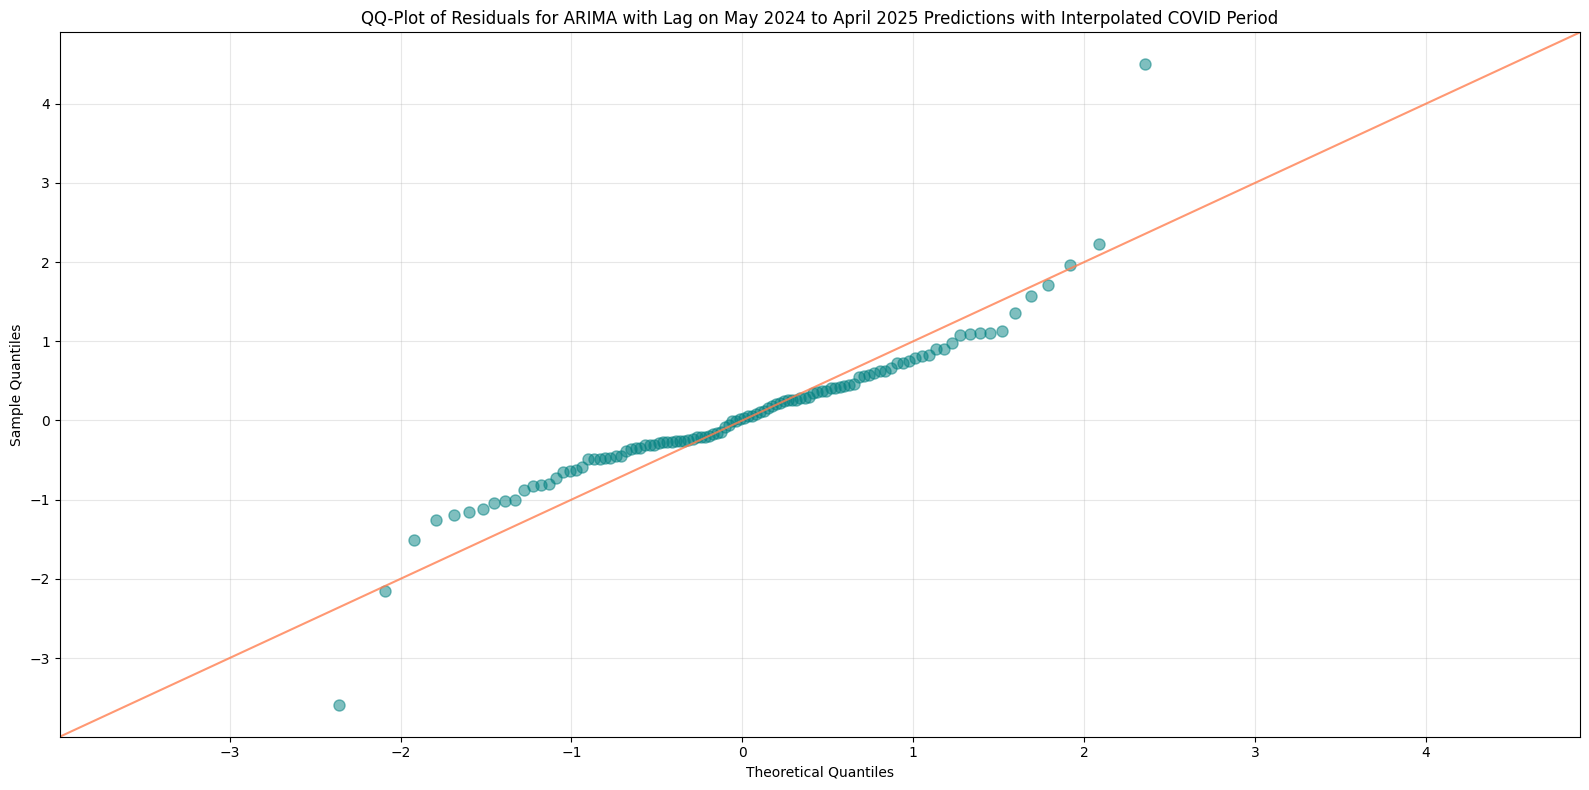

     lb_stat  lb_pvalue
1   0.008790   0.925304
2   0.236465   0.888489
3   0.270435   0.965490
4   0.272306   0.991531
5   0.328206   0.997079
6   0.465578   0.998233
7   0.550681   0.999239
8   0.554855   0.999802
9   0.722726   0.999854
10  0.833348   0.999926
11  0.835226   0.999980
12  2.507553   0.998134
13  3.454344   0.995733


In [302]:
# Create train and test set. Test set is last full season (1-year).
split_date = '2024-05-01'
train = data[data.index < split_date]
test = data[data.index >= split_date]

# Set parameters and initialise ARIMA model.
model = SARIMAX(
    train['Sales'],
    order=(1, 0, 12),
    seasonal_order=(0, 0, 0, 0),
    simple_differencing=False
)

# Fit model.
model_fit = model.fit(disp=False)

# Predict test set.
forecast = model_fit.forecast(steps=len(test))

# Test prediction residuals.
residuals = model_fit.resid

# Plot residuals on QQ-plot and print Ljun-Box test for first 10 lags.
title = 'QQ-Plot of Residuals for ARIMA with Lag on May 2024 to April 2025 Predictions with Interpolated COVID Period'
util.pt_model_fit(residuals=residuals, title=title, lj_lags=13)


# Visualisations for and Evaluations for Predictions with Interpolated COVID Period (1 Year):

The COVID period was interpolated using the slope between the pre-COVID year and post-COVID year. This created a trending season that captured a type of half-COVID half Normal season. The transformation had a positive impact on the model where we see that the large spike in the early months of the forecast is reduced. The results for MAPE show an accuracy of 98.10 % which matches to 105.04 million sales.

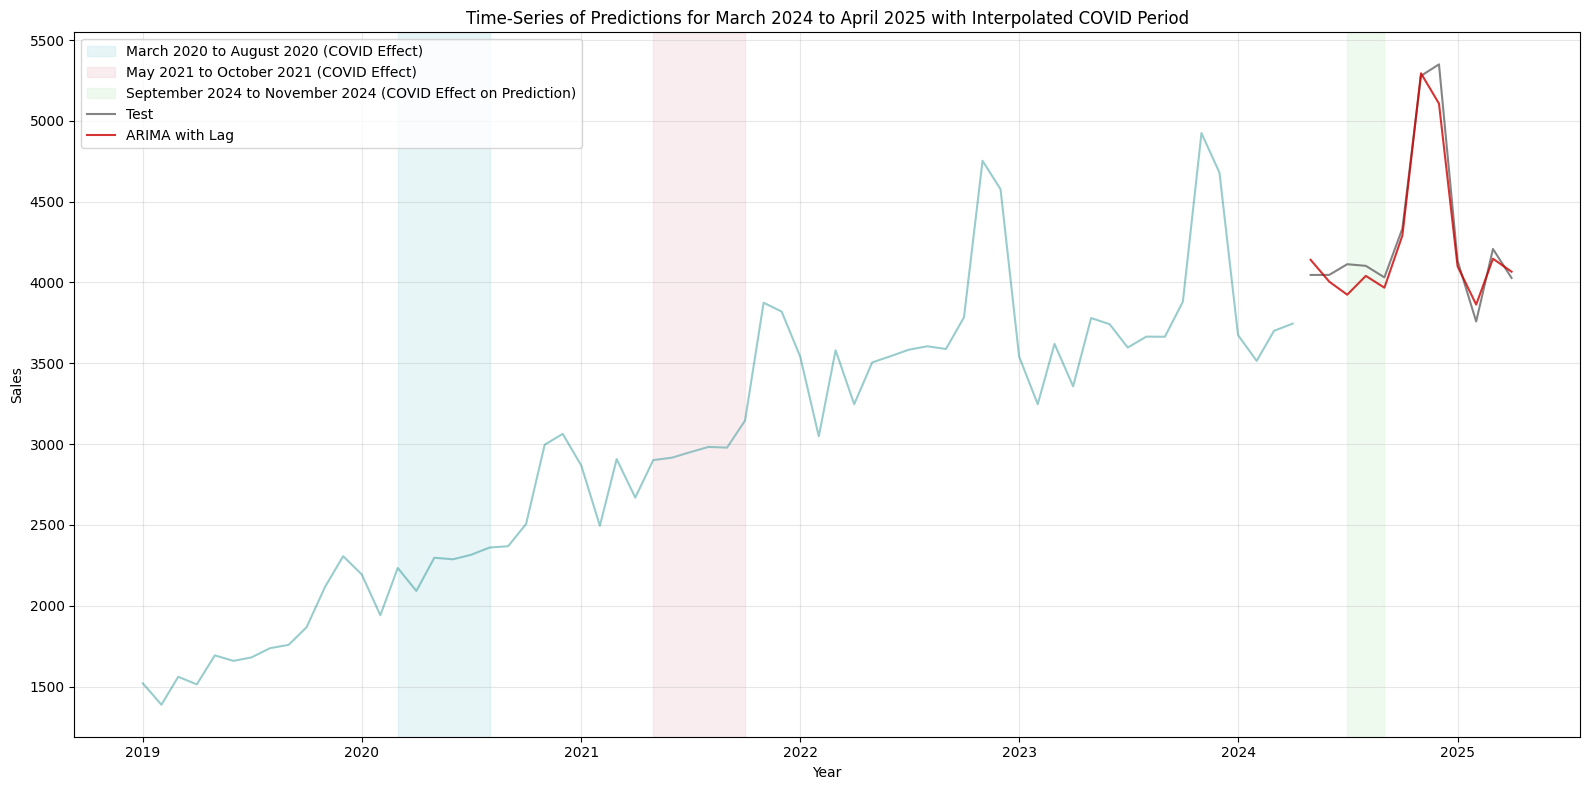

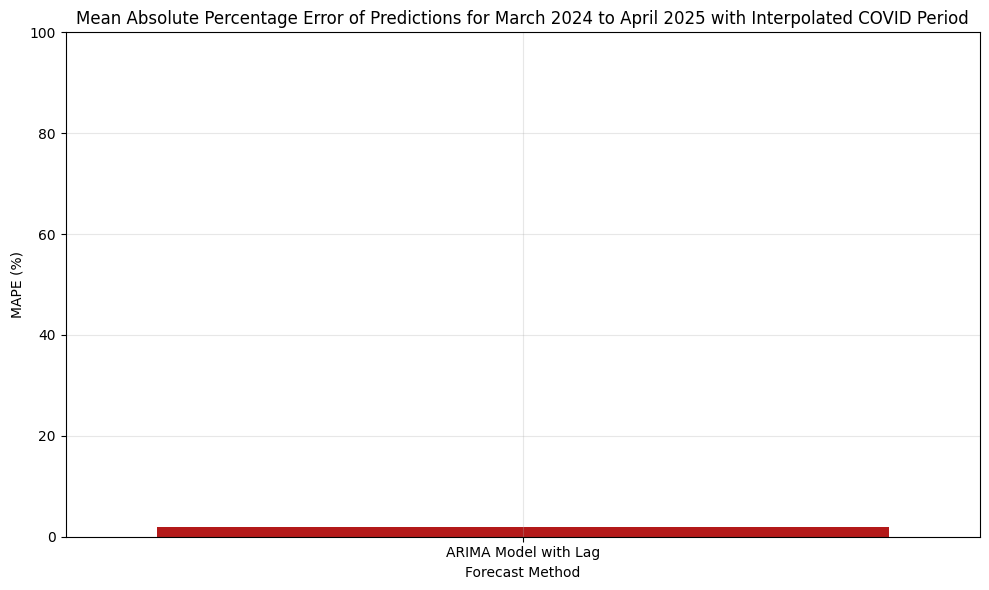

Mean Absolute Percentage Error for ARIMA Model with Lag: 1.905


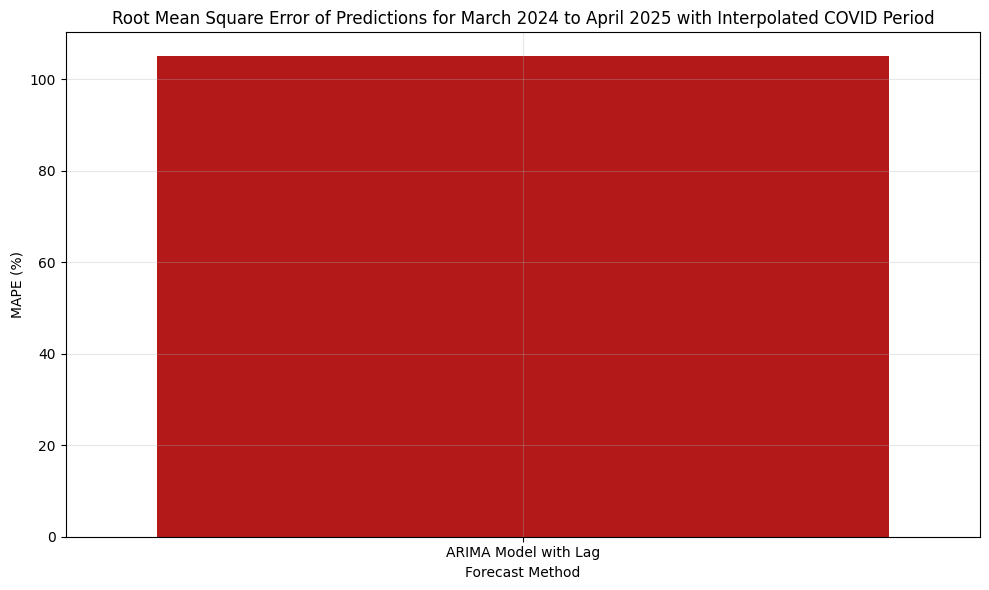

Root Mean Squared Error for ARIMA Model with Lag: 105.036


In [303]:
# The data is reconstructed to its original form (inverse transformed) with the train and test set.
# Create DataFrame with predictions.
dates = test.index
forecast = pd.DataFrame({'Sales': forecast.values}, index=dates)

# Concatenate data back before transformations.
x1 = pd.concat([train, forecast])
x2 = pd.concat([train, test])

# Inverse transformation.
x1 = util.inverse_transform(x1)
x2 = util.inverse_transform(x2)

# Split data again into train and test.
train = x1[x1.index < split_date]
pred_model = x1[x1.index >= split_date]
test = x2[x2.index >= split_date]

# Create dictionary of predictions.
preds = [
    {
        'data': pred_model['Sales'],
        'color': '#CC0000',
        'label': 'ARIMA with Lag'
    }
]

# Create dictionary of highlights.
highlights = [
    {
        'start': data.index[(data.index.year == 2020) & (data.index.month == 3)][0],
        'end': data.index[(data.index.year == 2020) & (data.index.month == 8)][0],
        'color': '#b0e0e6',
        'label': 'March 2020 to August 2020 (COVID Effect)'
    },
    {
        'start': data.index[(data.index.year == 2021) & (data.index.month == 5)][0],
        'end': data.index[(data.index.year == 2021) & (data.index.month == 10)][0],
        'color': "#f1c5cf",
        'label': 'May 2021 to October 2021 (COVID Effect)'
    },
    {
        'start': data.index[(data.index.year == 2024) & (data.index.month == 9)][0],
        'end': data.index[(data.index.year == 2024) & (data.index.month == 7)][0],
        'color': "#cdf0cd",
        'label': 'September 2024 to November 2024 (COVID Effect on Prediction)'
    }
]

# Reduce data to after 2019 for clearer visualisation.
train = train[train.index.year >= 2019]

# Plot predictions.
title = 'Time-Series of Predictions for March 2024 to April 2025 with Interpolated COVID Period'
util.pt_time(data=train, variable='Sales', highlights=highlights, test=test, preds=preds, title=title)

# Calculate MAPE for different predictions.
m_model = util.get_mape(y_true=test, y_pred=pred_model)

# Add MAPE predictions to dictionary.
mape_result = [
    {
        'label': 'ARIMA Model with Lag',
        'result': m_model,
        'color': '#CC0000'
    }
]

# Plot MAPE predictions.
title = 'Mean Absolute Percentage Error of Predictions for March 2024 to April 2025 with Interpolated COVID Period'
util.pt_preds(preds=mape_result, title=title, type_of='mape')

# Calculate MAPE for different predictions.
r_model = util.get_rmse(y_true=test, y_pred=pred_model)

# Add MAPE predictions to dictionary.
rmse_result = [
    {
        'label': 'ARIMA Model with Lag',
        'result': r_model,
        'color': '#CC0000'
    }
]

# Plot MAPE predictions.
title = 'Root Mean Square Error of Predictions for March 2024 to April 2025 with Interpolated COVID Period'
util.pt_preds(preds=rmse_result, title=title, type_of='rmse')

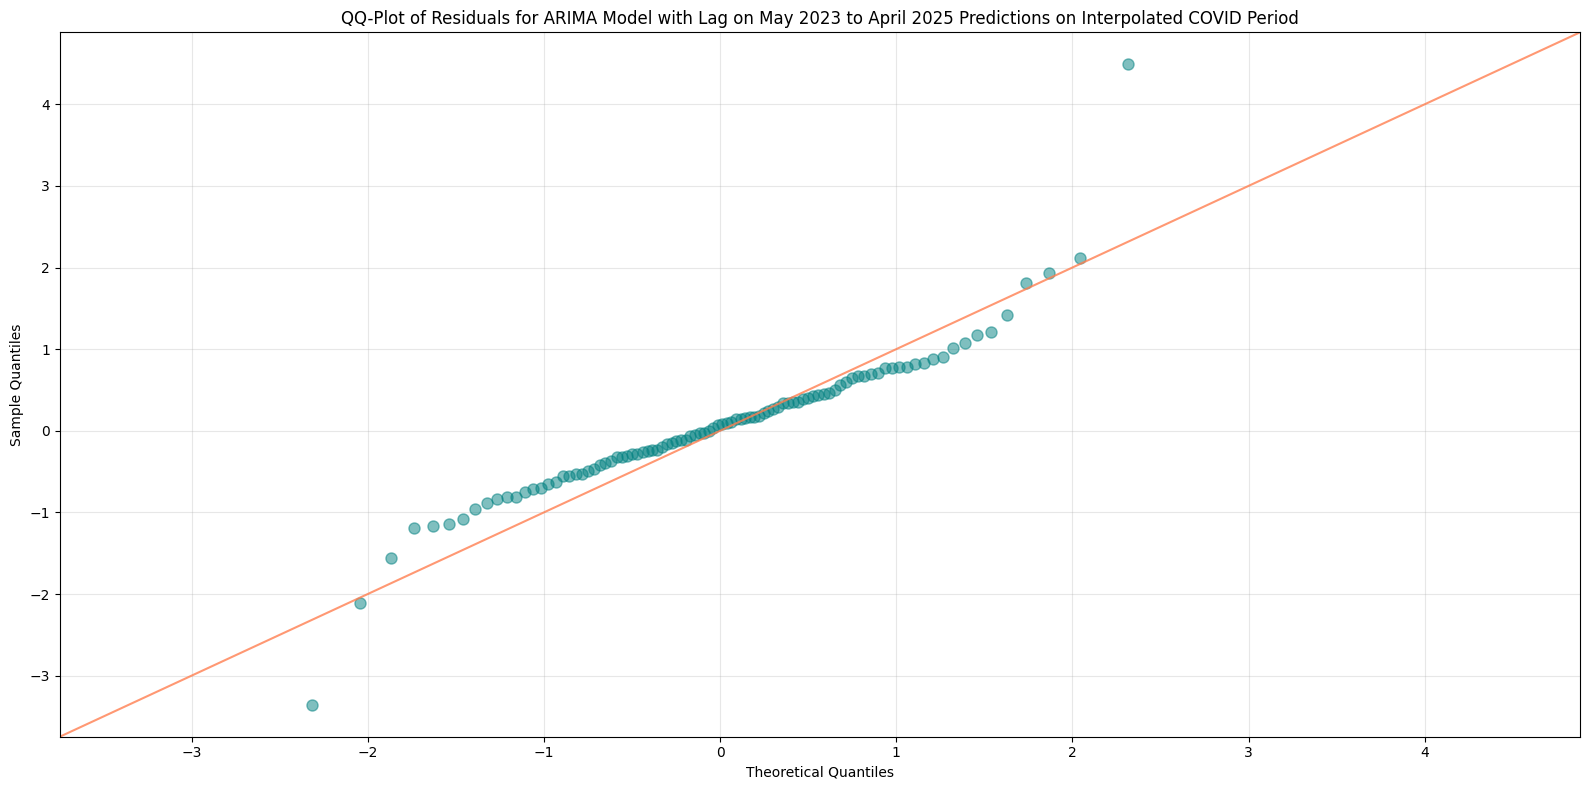

     lb_stat  lb_pvalue
1   0.021221   0.884179
2   0.188779   0.909928
3   0.192905   0.978726
4   0.231085   0.993818
5   0.233743   0.998707
6   0.236383   0.999748
7   0.298805   0.999901
8   0.445375   0.999914
9   0.474225   0.999976
10  0.528933   0.999991
11  0.534643   0.999998
12  1.151042   0.999969
13  1.814767   0.999870


In [307]:
# Create train and test set. Test set is last full season (1-year).
split_date = '2023-05-01'
train = data[data.index < split_date]
test = data[data.index >= split_date]

# Set parameters and initialise ARIMA model.
model = SARIMAX(
    train['Sales'],
    order=(1, 0, 12),
    seasonal_order=(0, 0, 0, 0),
    simple_differencing=False
)

# Fit model.
model_fit = model.fit(disp=False)

# Predict test set.
forecast = model_fit.forecast(steps=len(test))

# Test prediction residuals.
residuals = model_fit.resid

# Plot residuals on QQ-plot and print Ljun-Box test for first 10 lags.
title = 'QQ-Plot of Residuals for ARIMA Model with Lag on May 2023 to April 2025 Predictions on Interpolated COVID Period'
util.pt_model_fit(residuals=residuals, title=title, lj_lags=13)

# Visualisations for and Evaluations for Predictions with Interpolated COVID Period (2 Years):

The prediction was extended to two years for the interpolated data. The transformation and the ARIMA with Lag model had a high accuracy (97.73 %) for the forecast (121.44 million). This shows that interpolation can be an effective transformation for shock events that do not continue but should be considered with caution.

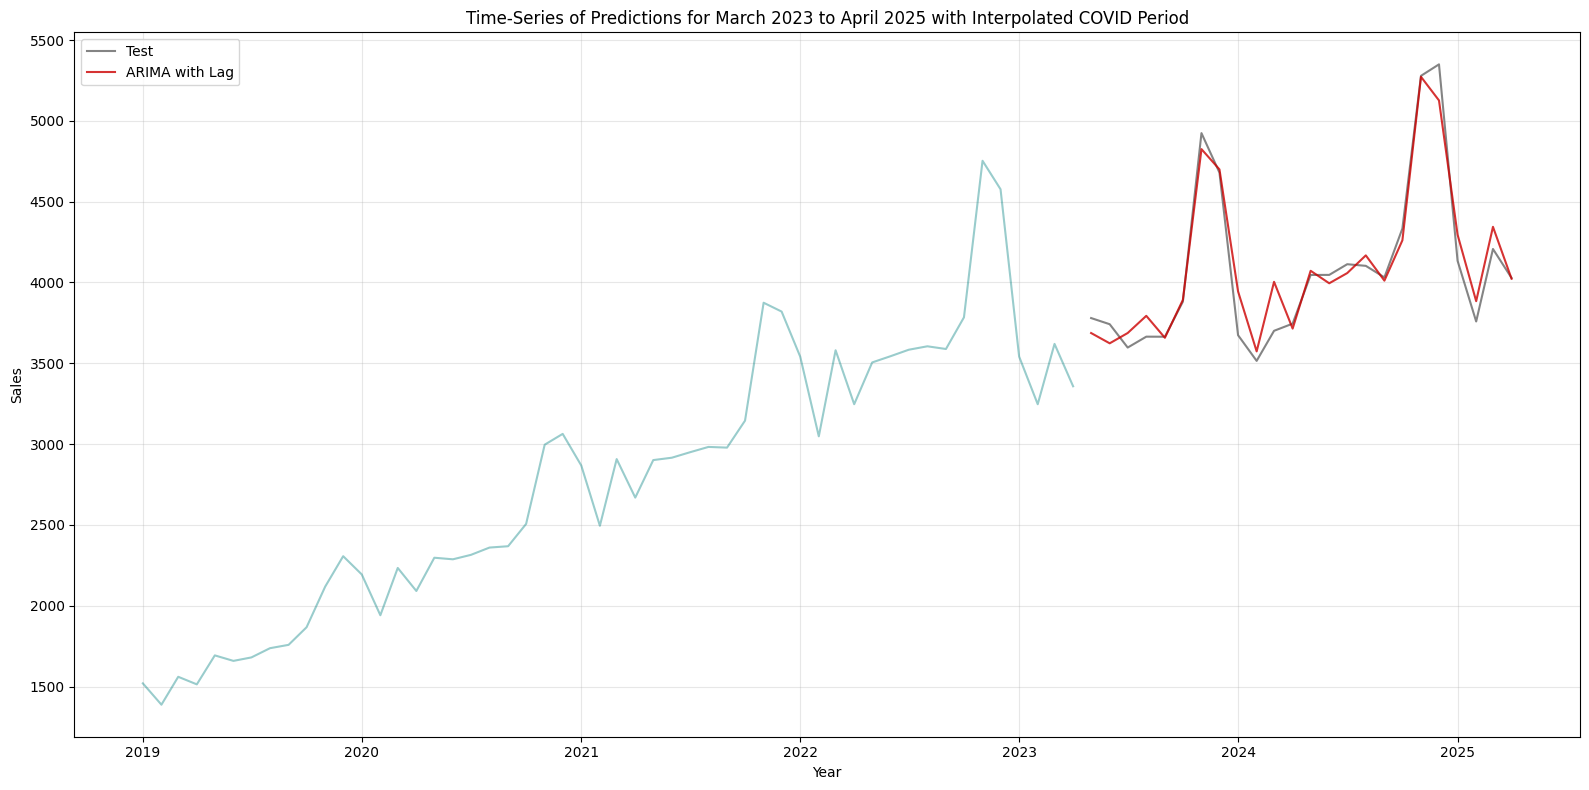

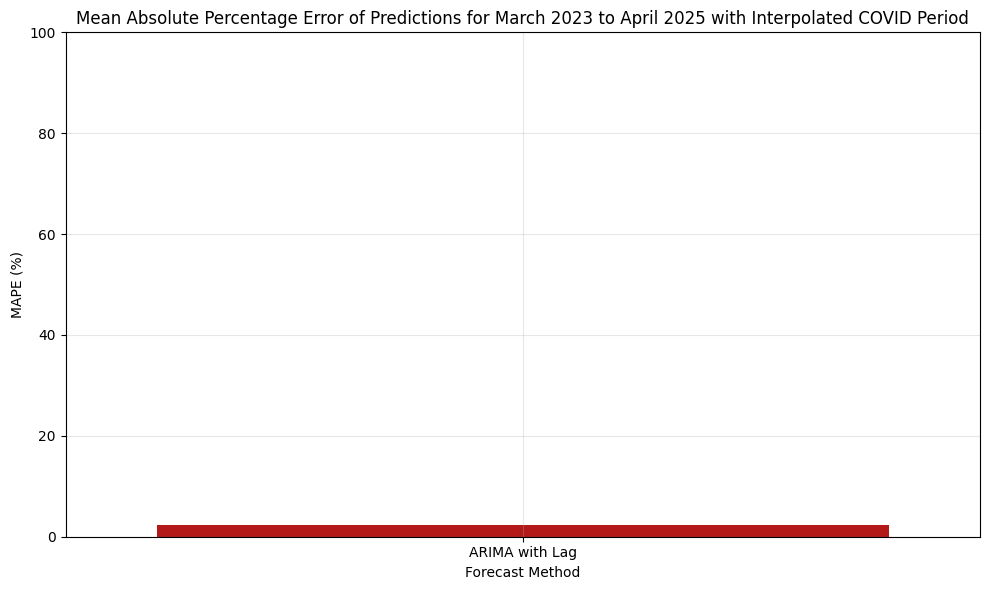

Mean Absolute Percentage Error for ARIMA with Lag: 2.271


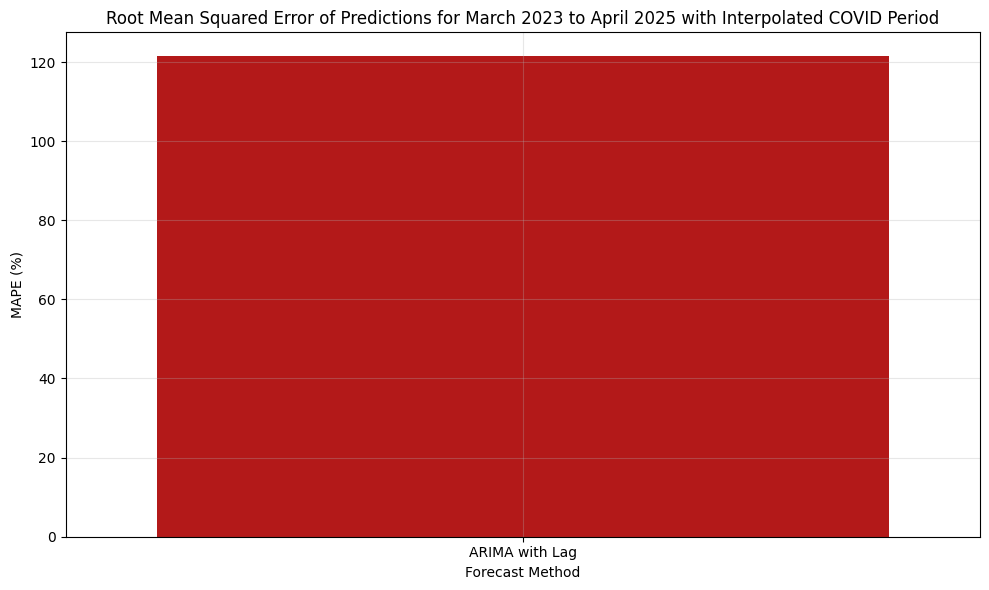

Root Mean Squared Error for ARIMA with Lag: 121.438


In [308]:
# The data is reconstructed to its original form (inverse transformed) with the train and test set.
# Create DataFrame with predictions.
dates = test.index
forecast = pd.DataFrame({'Sales': forecast.values}, index=dates)

# Concatenate data back before transformations.
x1 = pd.concat([train, forecast])
x2 = pd.concat([train, test])

# Inverse transformation.
x1 = util.inverse_transform(x1)
x2 = util.inverse_transform(x2)

# Split data again into train and test.
train = x1[x1.index < split_date]
pred_model = x1[x1.index >= split_date]
test = x2[x2.index >= split_date]

# Create dictionary of predictions.
preds = [
    {
        'data': pred_model['Sales'],
        'color': '#CC0000',
        'label': 'ARIMA with Lag'
    }
]

# Reduce data to after 2019 for clearer visualisation.
train = train[train.index.year >= 2019]

# Plot predictions.
title = 'Time-Series of Predictions for March 2023 to April 2025 with Interpolated COVID Period'
util.pt_time(data=train, variable='Sales', test=test, preds=preds, title=title)

# Calculate MAPE for different predictions.
m_model = util.get_mape(y_true=test, y_pred=pred_model)

# Add MAPE predictions to dictionary.
mape_result = [
    {
        'label': 'ARIMA with Lag',
        'result': m_model,
        'color': '#CC0000'
    }
]

title = 'Mean Absolute Percentage Error of Predictions for March 2023 to April 2025 with Interpolated COVID Period'
util.pt_preds(preds=mape_result, title=title, type_of='mape')

# Calculate MAPE for different predictions.
r_model = util.get_rmse(y_true=test, y_pred=pred_model)

# Add MAPE predictions to dictionary.
rmse_result = [
    {
        'label': 'ARIMA with Lag',
        'result': r_model,
        'color': '#CC0000'
    }
]

title = 'Root Mean Squared Error of Predictions for March 2023 to April 2025 with Interpolated COVID Period'
util.pt_preds(preds=rmse_result, title=title, type_of='rmse')